In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


In [6]:
data.set_index('PUF_ID', inplace=True)

# Data exploration

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6394 entries, 10350 to 8516
Columns: 216 entries, sample to finalwt
dtypes: float64(2), int64(214)
memory usage: 10.6 MB


In [8]:
data.head()

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,3,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,2,2,3,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,3,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,3,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,3,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


In [9]:
max(data.isna().sum()) # no explicit missing values

0

In [10]:
data.columns.values

array(['sample', 'fpl', 'SWB_1', 'SWB_2', 'SWB_3', 'FWBscore', 'FWB1_1',
       'FWB1_2', 'FWB1_3', 'FWB1_4', 'FWB1_5', 'FWB1_6', 'FWB2_1',
       'FWB2_2', 'FWB2_3', 'FWB2_4', 'FSscore', 'FS1_1', 'FS1_2', 'FS1_3',
       'FS1_4', 'FS1_5', 'FS1_6', 'FS1_7', 'FS2_1', 'FS2_2', 'FS2_3',
       'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS', 'PROPPLAN_1',
       'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'MANAGE1_1', 'MANAGE1_2',
       'MANAGE1_3', 'MANAGE1_4', 'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1',
       'AUTOMATED_2', 'ASK1_1', 'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1',
       'CHANGEABLE', 'GOALCONF', 'LMscore', 'FINKNOWL1', 'FINKNOWL2',
       'FINKNOWL3', 'FK1correct', 'FK2correct', 'FK3correct', 'KHscore',
       'KHKNOWL1', 'KHKNOWL2', 'KHKNOWL3', 'KHKNOWL4', 'KHKNOWL5',
       'KHKNOWL6', 'KHKNOWL7', 'KHKNOWL8', 'KHKNOWL9', 'KH1correct',
       'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct',
       'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct', 'ENDSMEET',
       'H

## Dropping irrelevant features

In [11]:
FWB_cols = list(filter(lambda x: 'FWB' in x, data.columns.values))
data.drop(FWB_cols[1:], axis = 1, inplace = True)

FS_cols = list(filter(lambda x: 'FS' in x, data.columns.values))
data.drop(FS_cols[1:], axis = 1, inplace = True)

LM_cols = list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))
data.drop(LM_cols, axis = 1, inplace = True)

FKcorrect_cols = ['FK1correct', 'FK2correct', 'FK3correct']
data.drop(FKcorrect_cols, axis = 1, inplace = True)

KH_cols = list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))
data.drop(KH_cols, axis = 1, inplace = True)

KHcorrect_cols = ['KH1correct', 'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct', 'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct']
data.drop(KHcorrect_cols, axis = 1, inplace = True)

OBJNUMcols = list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))
data.drop(OBJNUMcols, axis = 1, inplace = True)

In [12]:
data.shape

(6394, 171)

## Missing data

- -5: County not known (Applies to PCTLT200FPL. County was not known for these respondents and details on the county-level degree of poverty could not be merged in for these cases.) ACTION: 395 rows

- -4: Response not written to the database due to error (SWB and FWB variables) ACTION: only one record -> drop (?)

- -3: Invalid response/ Incoherent data (SOCSEC2, SOCSEC3, KIDS) ACTION: 234 rows for SOCSEC + 1 row for KIDS_2 drop(?)

- -2: Question not asked because respondant not in item base (VALUERANGES, MORTGAGE, PAIDHELP, SOCSEC1, SOCSEC2, SOCSEC3, LIFEEXPECT and RETIRE). The respondent was correctly skipped over this item based on responses to previous questions or panel data on respondant age ACTION: ? pesquisar

- 8: I can’t recall (HSLOC) ACTION: 21 rows -> impute with mode (?)

- -1: Not answered/ Left blank (Applies to most items) ACTION: 2302 rows with missing data (impute; see how to impute each case specifically)


- 98: Don't know (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES) ACTION: 514 rows -> impute

- 99: Prefer not to say (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES,  EMPLOY: Analysis variable of EMPLOY1-9 -> if EMPLOY did not select any, it is a missing value) ACTION: 1466 rows -> impute

__-5: County not known__

PCTLT200FPL: percentage of people who live in the same county as the survey respondent who have an income that is below 200% of the federal poverty level

-5 when unkown county of the responded

395 rows

How to solve this?
- impute: The narrowest information we have about respondant's residence is the census division. If we imputed with the census division percentage of people with income below 200% of FPL, all imputed values would be 0. Instead, it would be better to use a KNNimputer: variables that possibly relate people that live in the same county: Census division (PPREG9), Household income (PPINCIMP), Education (PPEDUC), Age (agecat), Financial Hardship (MATHARDSHIP_1 - MATHARDSHIP_6)

In [13]:
nrows = data[data['PCTLT200FPL'].isna()].shape[0]
print(f'nr of rows with missing value: {nrows}')

nr of rows with missing value: 0


In [14]:
data = data.replace(-5, np.nan)

In [15]:
data['PCTLT200FPL'].value_counts()

0.0    4548
1.0    1451
Name: PCTLT200FPL, dtype: int64

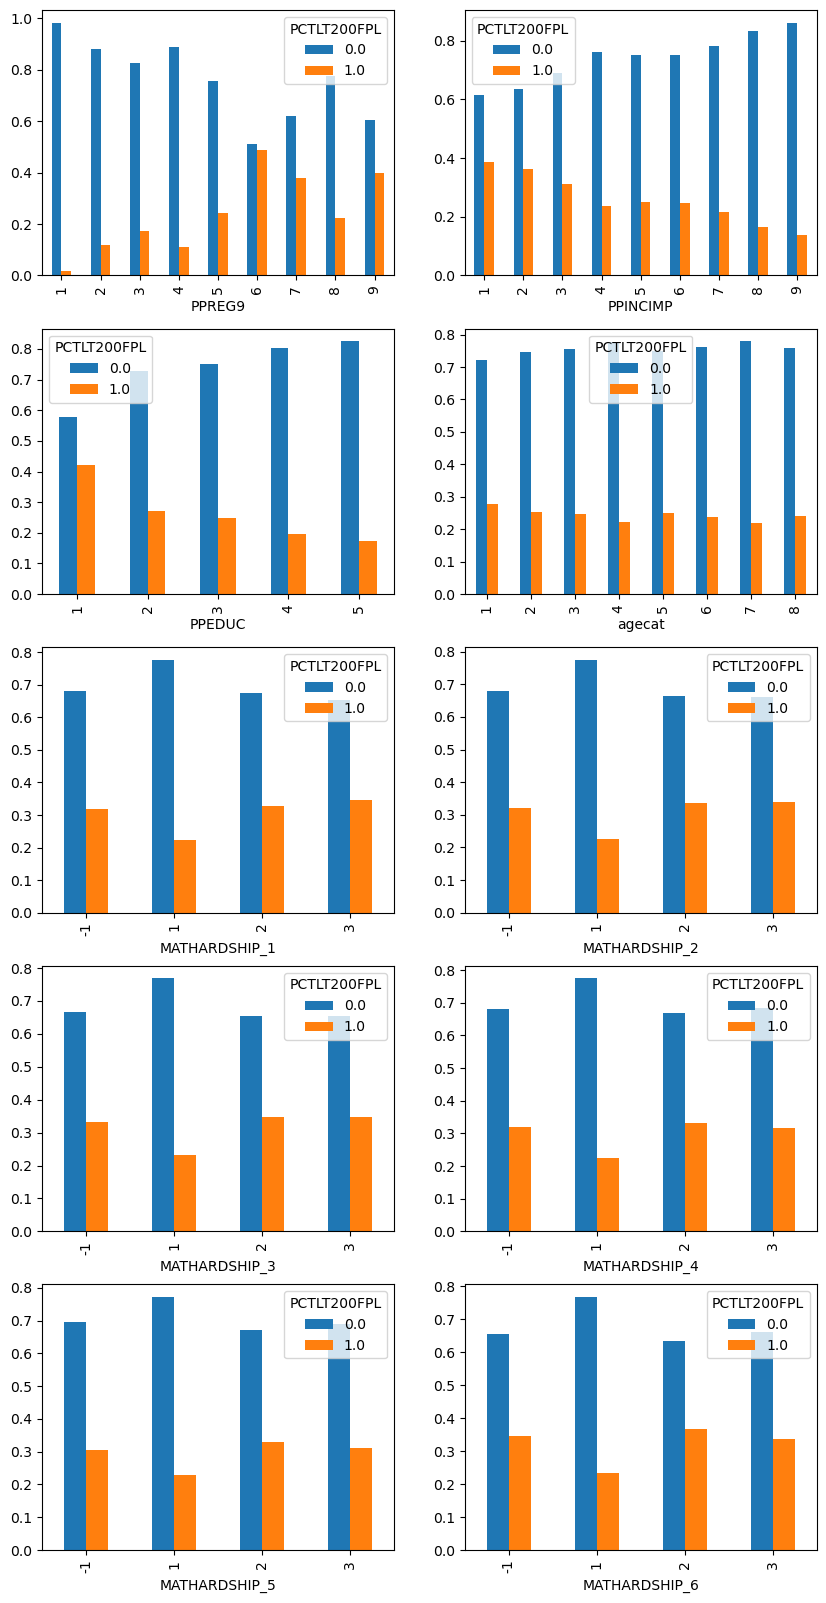

In [16]:
feats = ['PPREG9', 'PPINCIMP', 'PPEDUC', 'agecat', 'MATHARDSHIP_1', 'MATHARDSHIP_2', 'MATHARDSHIP_3', 'MATHARDSHIP_4', 'MATHARDSHIP_5', 'MATHARDSHIP_6']

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(1, 11):
    data.groupby(feats[i-1])['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

In [17]:
data = data.replace(np.nan, -5)

Conclusion: KNN using PPREG9, PPINCIMP and PPEDUC

__-4: Response not written to the database due to error__

SWB and FWB

How to solve this?
- drop: only one row affected

In [18]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,48,7,4,3,...,1,3,5,0,0,0,0,1,0.0,1.253964


In [19]:
data.drop(12173, inplace = True)

__-3: Invalid response/ Incoherent data__

SOCSEC2, SOCSEC3, KIDS_2

SOCSEC2: 'At what age did you begin receiving benefits'. Invalid when answered < 62 years

SOCSEC3: 'Age likely to start receiving Social Security retirement benefits'. Invalid when respondant age is two or more year greater than given response

KIDS_2 asks for the number of children of age between 7 to 12 that the respondent supports financially

235 rows with invalid data
- 166 from SOCSEC2
- 68 from SOCSEC3
- 1 from KIDS_2

What to do?
- set SOCSEC2 to -2 because response is invalid
- impute SOCSEC3 the same way as SOCSEC2
- drop KIDS_2

In [20]:
data[data['SOCSEC2'] == -3].shape[0]

166

In [21]:
data[data['SOCSEC3'] == -3].shape[0]

68

In [22]:
data[data['KIDS_2'] == -3].shape[0]

1

In [23]:
data = data.replace(-3, np.nan)

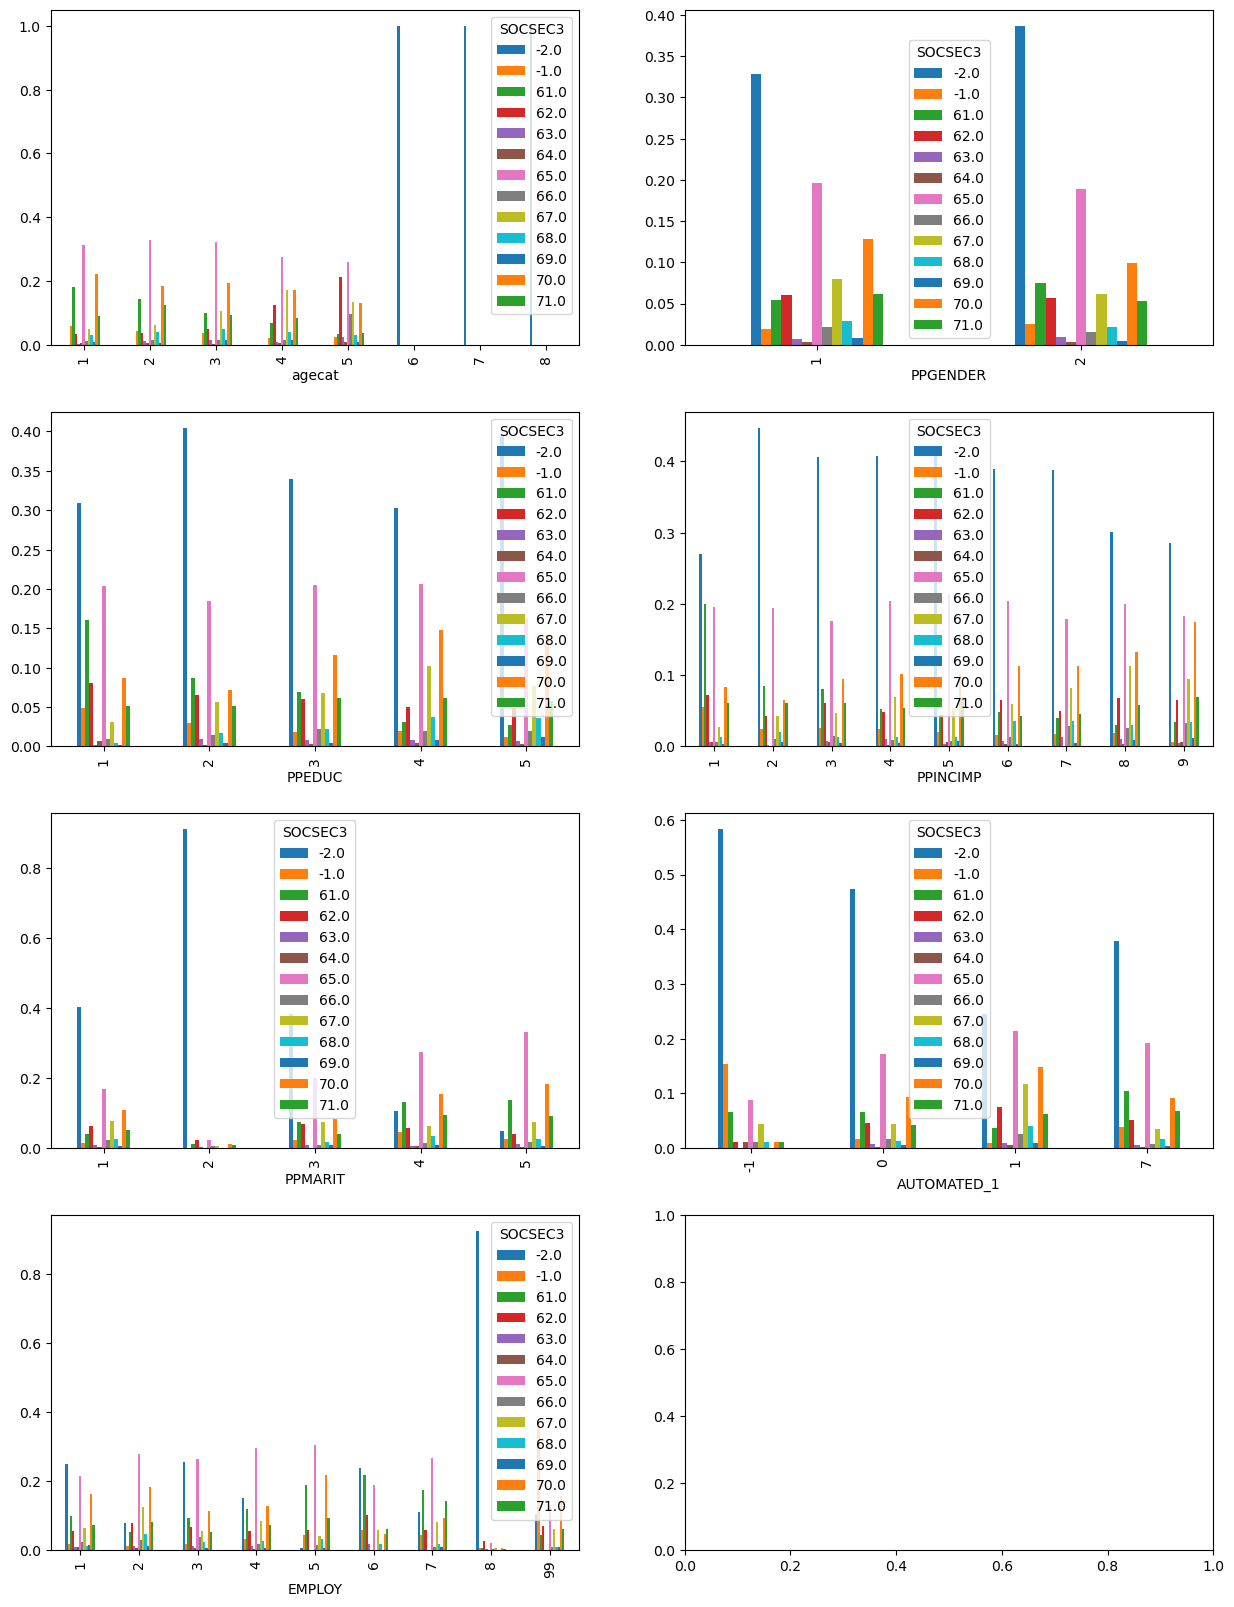

In [24]:
feats = ['agecat', 'PPGENDER', 'PPEDUC', 'PPINCIMP', 'PPMARIT', 'AUTOMATED_1', 'EMPLOY']

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
for i in range(1, 8):
    data.groupby(feats[i-1])['SOCSEC3'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

No variable looks like distigushing well among likely age of SOCSEC3. Let's look at its distribution

<AxesSubplot:xlabel='SOCSEC3', ylabel='count'>

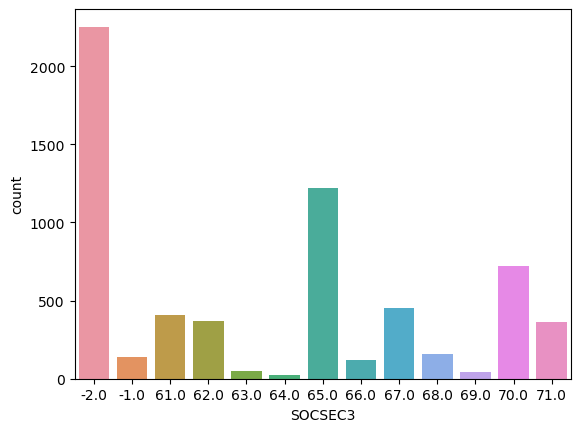

In [25]:
sns.countplot(x = 'SOCSEC3', data = data) # kinda normal distributed. Let's impute with the mode

In [26]:
data = data.replace(np.nan, -3)

__-2: Question not asked because respondant not in item base__

What to do?
- search!!!

In [27]:
data[(data == -2).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,44,5,4,3,...,1,4,8,0,0,0,0,1,0.0,0.367292
7740,1,3,6,6,6,51,43,5,4,3,...,1,2,3,0,0,0,0,2,0.0,1.327561
13699,1,3,4,3,4,49,42,5,3,3,...,1,4,9,0,0,0,1,2,1.0,0.835156
7267,1,3,6,6,6,49,42,-1,-1,-1,...,1,3,7,0,0,0,0,1,0.0,1.410871
7375,1,3,4,4,4,49,42,4,3,3,...,1,2,4,0,0,1,0,4,1.0,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11220,3,3,6,7,7,61,47,5,5,4,...,1,2,3,0,0,0,1,2,-5.0,0.522504
13118,3,2,7,7,7,59,59,6,4,4,...,1,3,6,0,0,0,0,3,-5.0,1.015219
8709,1,3,5,6,6,59,51,4,4,4,...,1,1,2,0,0,0,0,2,0.0,1.136270


__8: I can't recall__

HSLOC: Where respondent attended high school
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

What do to?
- impute with mode

In [28]:
data['HSLOC'].value_counts()

 1    5386
-1     644
 2     342
 8      21
Name: HSLOC, dtype: int64

__-1: Not answered/ Left blank__

2301 rows

__98: Don't know__

514 rows

__99: Prefer not to say__


1384 rows in total

- 624 from HOUSERANGES
- 159 from VALUERANGES
- 498 from MORTGAGE
- 988 from SAVINGSRANGES
- 116 from EMPLOY



What to do?
- SWB: median
- SUBKNOWL1: median
- ACT: KNNImputerMode
- FINGOALS: KNNImputerMode
- PROPLAN: drop
- MANAGE: mode + knn
- SAVEHABIT: KNNImputerMode
- FRUGALITY: mode
- AUTOMATED: KNNImputerMode
- ASK: KNNImputerMode + mode
- SUBNUMERACY: KNNImputerMode + mode
- CHANGEABLE: mode
- GOALCONF: KNNImputerMode
- ENDSMEET: KNNImputerMode
- HOUSING:
- LIVINGARRANGEMENT:
<br>
- HOUSERANGES:
- VALUERANGES:
- MORTGAGE:
- SAVINGSRANGES:
<br>
- CONSPROTECT:
- EARNERS:
- VOLATILITY:
- SNAP:
- MATHARDSHIP:
- COLLECT:
- REJECTED:
- ABSORBSHOCK:
- BENEFITS:
- FRAUD2:
- COVERCOSTS:
- BORROW:
- MANAGE2:
- PAIDHELP:
- HSLOC:
- PAREDUC:
- FINSOC:
- MATERIALISM:
- CONNECT:
- HEALTH:
- SCFHORIZON:
- DISCOUNT:
- MEMLOSS:
- DISTRESS:
- SELFCONTROL:
- OUTLOOK:
- PEM:
- HOUSESAT:
- SOCSEC:
- LIFEEXPECT:
- HHEDUC:
- KIDS:
<br>
- EMPLOY
<br>
- RETIRE:
- MILITARY:
- Military_Status:

In [29]:
data[(data == -1).any(axis = 1)].shape[0]

2244

In [30]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 98).any(axis = 1)].shape[0]

514

In [31]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 99).any(axis = 1)].shape[0]

1384

In [32]:
data = data.replace(-1, np.nan)
data = data.replace(98, np.nan)
data = data.replace(99, np.nan)

Let's see the number of missing values per row to try to exclude rows with too many missing values

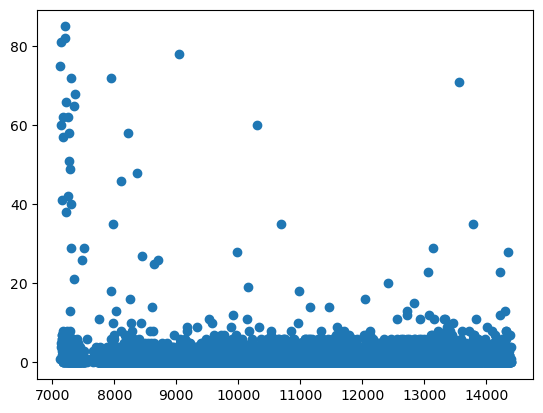

In [33]:
plt.scatter(data.isna().sum(axis = 1).index, data.isna().sum(axis = 1))

There are 171 columns, so any row with more than 5 missing values will be excluded

In [34]:
data[data.isna().sum(axis = 1) >= 5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1,3,7,0,0,0,0,1,0.0,1.410871
8303,1,3,7.0,7.0,7.0,43.0,58.0,4.0,3.0,3.0,...,1,3,7,0,0,0,1,3,0.0,2.497838
9182,1,3,6.0,NaN,NaN,50.0,43.0,4.0,4.0,3.0,...,1,4,9,0,0,0,0,2,0.0,0.647301
11082,1,3,6.0,6.0,5.0,62.0,55.0,4.0,5.0,4.0,...,1,3,5,0,0,0,0,3,0.0,0.455829
8309,2,3,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1,3,5,0,0,0,0,1,0.0,0.597089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11078,3,1,3.0,4.0,5.0,26.0,44.0,4.0,3.0,3.0,...,1,2,3,0,1,0,0,1,-5.0,1.379959
12353,1,3,5.0,7.0,3.0,62.0,26.0,4.0,3.0,3.0,...,1,3,5,0,0,0,0,2,0.0,1.745759
12297,3,3,4.0,5.0,7.0,55.0,45.0,5.0,4.0,3.0,...,1,2,4,0,0,0,1,2,-5.0,0.883213


In [38]:
data.drop(data[data.isna().sum(axis = 1) >= 5].index, axis = 0, inplace = True)

In [36]:
data.shape

(6178, 171)

Only 367 rows will be excluded

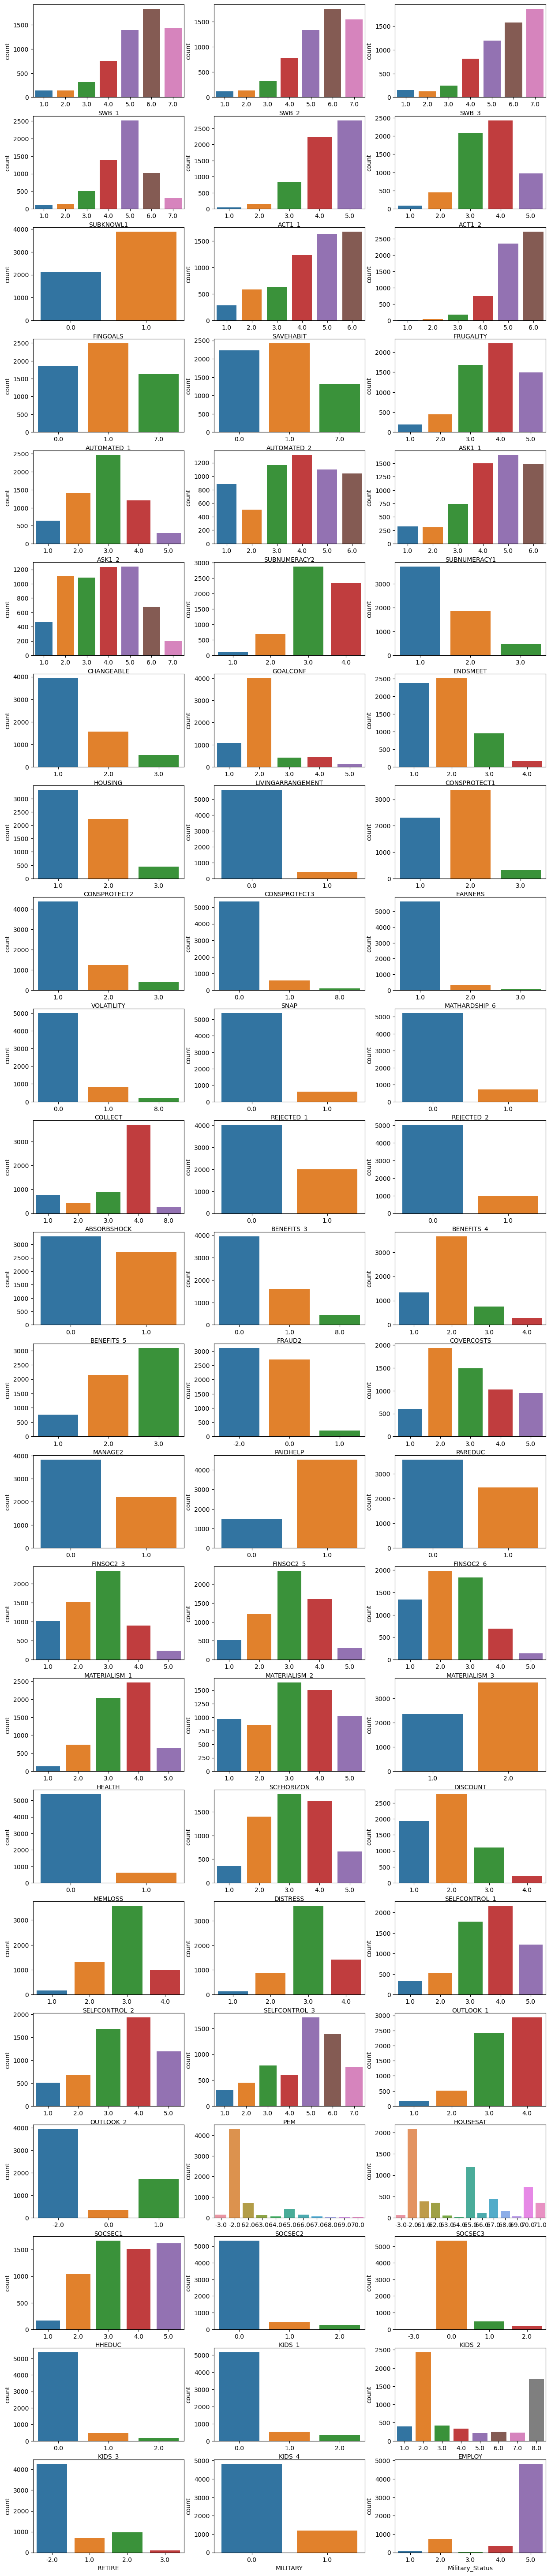

In [44]:
cols = ['SWB_1', 'SWB_2', 'SWB_3', 'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS',
'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1', 'AUTOMATED_2', 'ASK1_1',
'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1', 'CHANGEABLE', 'GOALCONF',
'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'CONSPROTECT1',
'CONSPROTECT2', 'CONSPROTECT3', 'EARNERS', 'VOLATILITY', 'SNAP',
'MATHARDSHIP_6', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'ABSORBSHOCK',
'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS',
'MANAGE2', 'PAIDHELP', 'PAREDUC', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6',
'MATERIALISM_1', 'MATERIALISM_2', 'MATERIALISM_3', 'HEALTH',
'SCFHORIZON', 'DISCOUNT', 'MEMLOSS', 'DISTRESS', 'SELFCONTROL_1',
'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM',
'HOUSESAT', 'SOCSEC1', 'SOCSEC2', 'SOCSEC3', 'HHEDUC', 'KIDS_1',
'KIDS_2', 'KIDS_3', 'KIDS_4', 'EMPLOY', 'RETIRE', 'MILITARY',
'Military_Status']

fig, axs = plt.subplots(23, 3, figsize=(15, 75))

for i in range(1, 70):
    # sns countplot on axis
    sns.countplot(x = cols[i - 1], data = data, ax = axs[(i - 1 )// 3, (i-1) % 3])

Mode imputation: This involves replacing the missing values with the most frequent value in the ordinal feature. This method is most appropriate when the feature is niminal or when it is ordinal and has a few missing values

Median imputation: This involves replacing the missing values with the median value of the ordinal feature. This method is most appropriate when the ordinal feature has a skewed distribution.

Ordinal:

SWB_1, SWB_2, SUBKNOWL_1, ACT1_2, ASK1_1, SUBNUMERACY1, LIVINGARRANGEMENT, CONSPROTECT1, ABSORBSHOCK, PAREDUC, MATERIALISM_3, HEALTH, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3, OUTLOOK_1, OUTLOOK_2, PEM: skewed -> median

SWB_3, ACT1_1, SAVEHABIT, FRUGALITY, ENDSMEET, CONSPROTECT2, MATHARDSHIP_6, HOUSESAT: staricase -> mode

AUTOMATED_1, AUTOMATED_2, ASK1_2, SUBNUMERACY2, CHANGEABLE, GOALCONF, EARNERS, MATERIALISM,_1, MATERIALISM_2, SCFHORIZON, DISTRESS, HHEDUC, EMPLOY, RETIRE (cuidado com -2): gaussian distribution -> mode

PAID
Categorical:

FINGOALS, AUTOMATED_2, HOUSING, CONSPROTECT3, VOLATILITY, SNAP, COLLECT, REJECTED_1, REJECTED_2, BENEFITS_3, BENEFITS_4, BENEFITS_5, FRAUD2, COVERCOSTS, MANAGE2, PAIDHELP (cuidado com -2), FINSOC2_3, FINSOC2_5, FINSOC2_6, DISCOUNT, MEMLOSS, SOCSEC1, SOCSEC2, SOCSEC3 (cuidado com -3 e -2), KIDS_1, KIDS_2, KIDS_3, KIDS_4, EMPLOY, MILITARY, Military_Status: mode

__SBW: Subjective well-being and optimism questions__

'I am satisfied with my life'
<br>
'I am optimistic about my future'
<br>
'If I work hard today, I will be more succeful in the future'

It is hard to fill subjective data. Given the small amount of records with missing data and giving the large size of the dataset, a good approach is to use the median.

In [35]:
data[list(filter(lambda x: 'SWB' in x, data.columns.values))].isna().sum()

SWB_1    14
SWB_2    42
SWB_3    43
dtype: int64

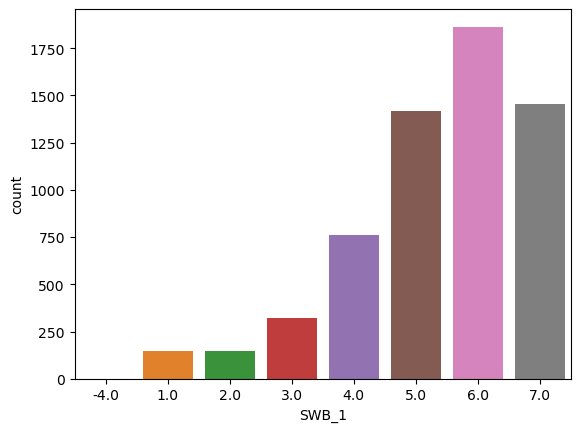

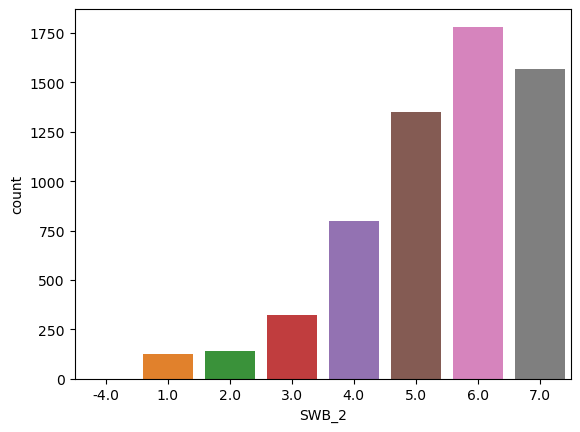

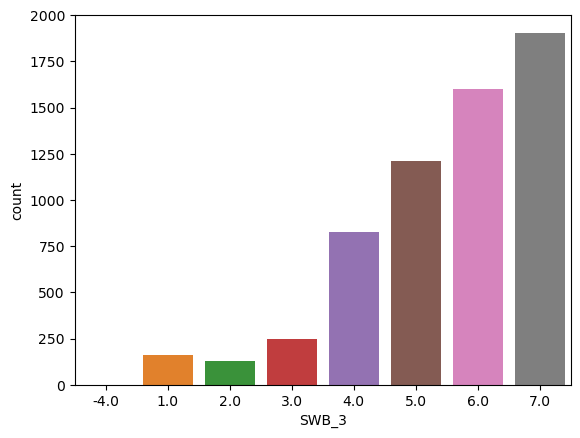

In [36]:
for feat in list(filter(lambda x: 'SWB' in x, data.columns.values)):
    sns.countplot(x = feat, data = data)
    plt.show()

Median imputation is appropriate for variables with a skewed distribution that are continuous or ordinal.

__SUBKNOWL1: How would you assess your overall financial knowledge?__

Similarly to SWB questions, it is hard to fill subjective data. Given the small amount of records with missing data and giving the large size of the dataset, a good approach is to use the median.

In [178]:
data[data['SUBKNOWL1'].isna()].shape

(38, 171)

__ACT__

'I follow-through on my financial commitments to others'
<br>
'I follow-through on financial goals I set to myself'

This questions are about financial responsibility and accountability, therefore we can use KNN to impute the missing values.

The other questions of this kind are FINGOALS, PROPPLAN, MANAGE and ASK:

'Do you have a current or recent financial goal?'
<br>
'I consult my budget to see how much money I have left'
<br>
'I actively consider the steps I need to take to stick to my budget'
<br>
'I set financial goals for what I want to achieve with my money'
<br>
'I prepare a clear plan of action w/ detailed steps to achieve my financial goals'
<br>
'Paid all your bills on time'
<br>
'Stayed within your budget or spending plan'
<br>
'I do my own research before making decisions involving money'
<br>
'I ask other people their opinions before making decisions involving money'

People with similar answers in this questions should have similar answer to ACT questions

In [179]:
data[list(filter(lambda x: 'ACT' in x, data.columns.values))].isna().sum()

ACT1_1    14
ACT1_2     8
dtype: int64

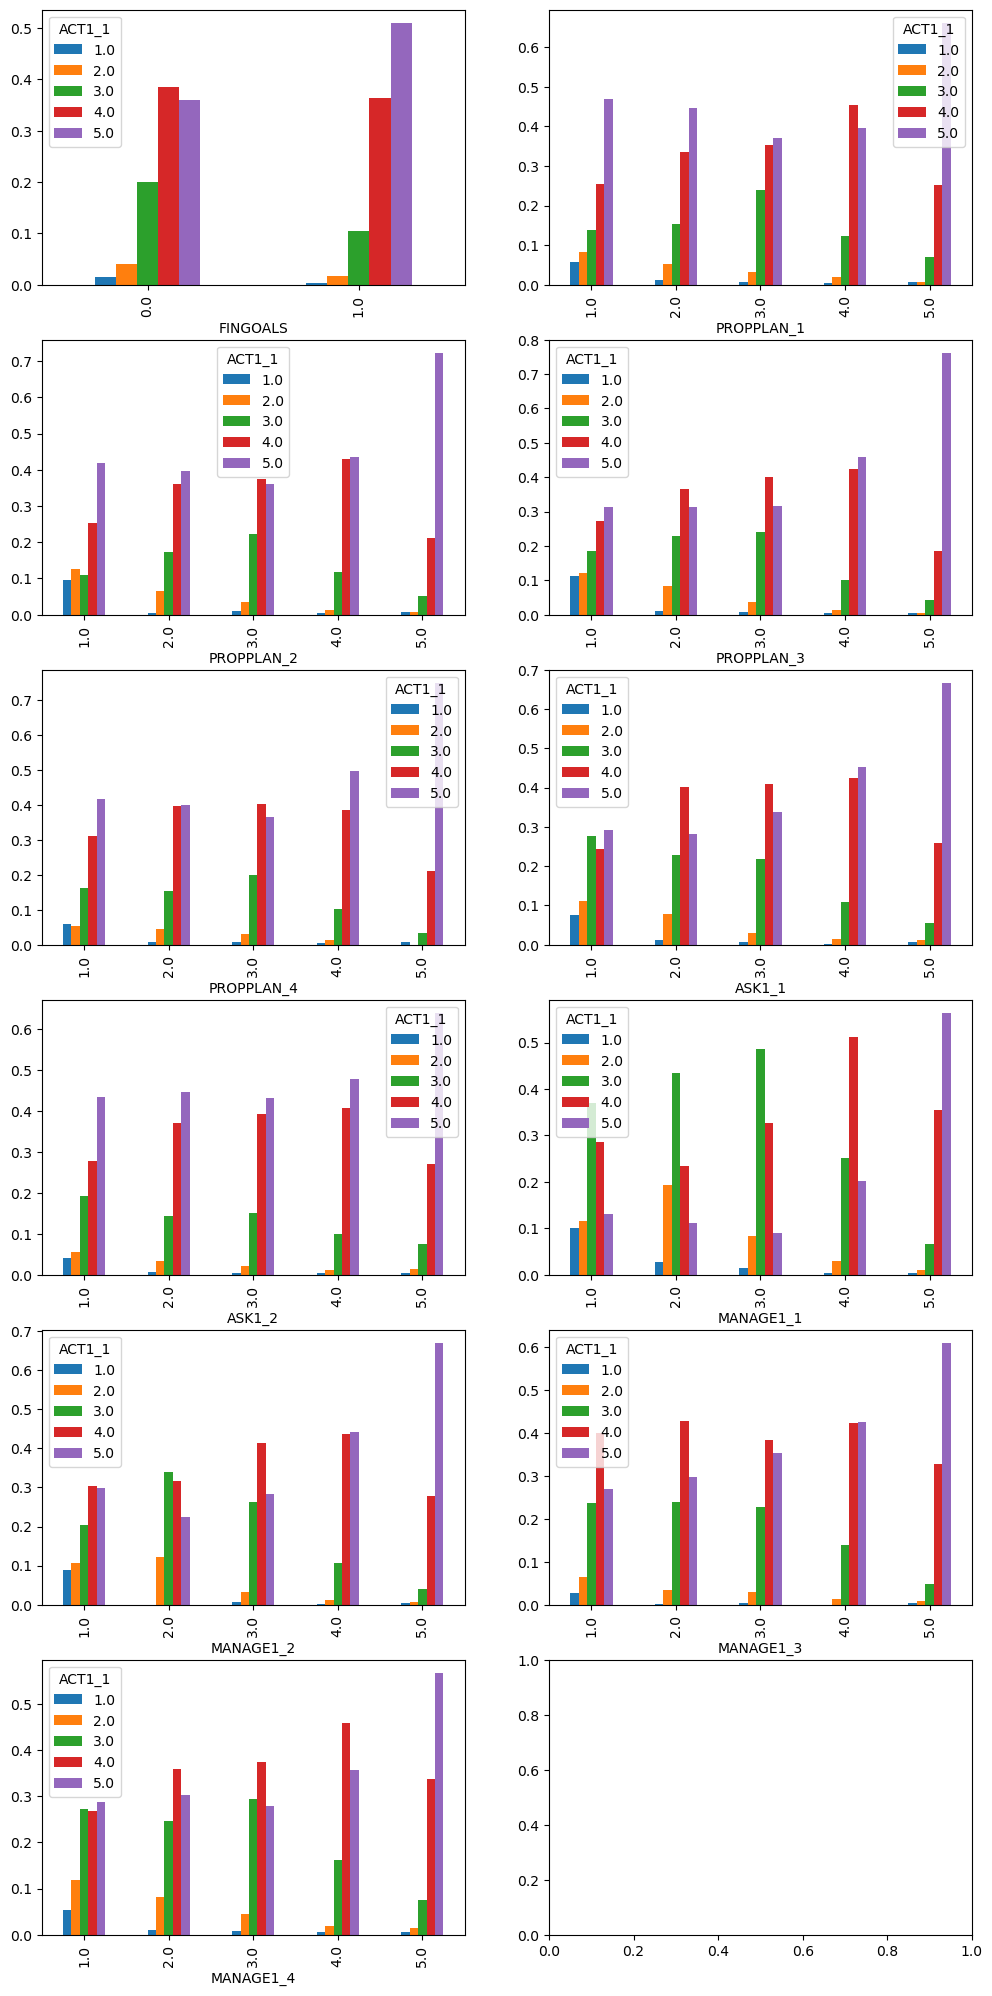

In [184]:
fig, axs = plt.subplots(6, 2, figsize=(12, 25))

feats = ['FINGOALS', 'PROPPLAN_1', 'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'ASK1_1', 'ASK1_2', 'MANAGE1_1', 'MANAGE1_2', 'MANAGE1_3', 'MANAGE1_4']
for i in range(1, 12):
    data.groupby(feats[i - 1])['ACT1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Now, let's see what happpens with ACT1_2

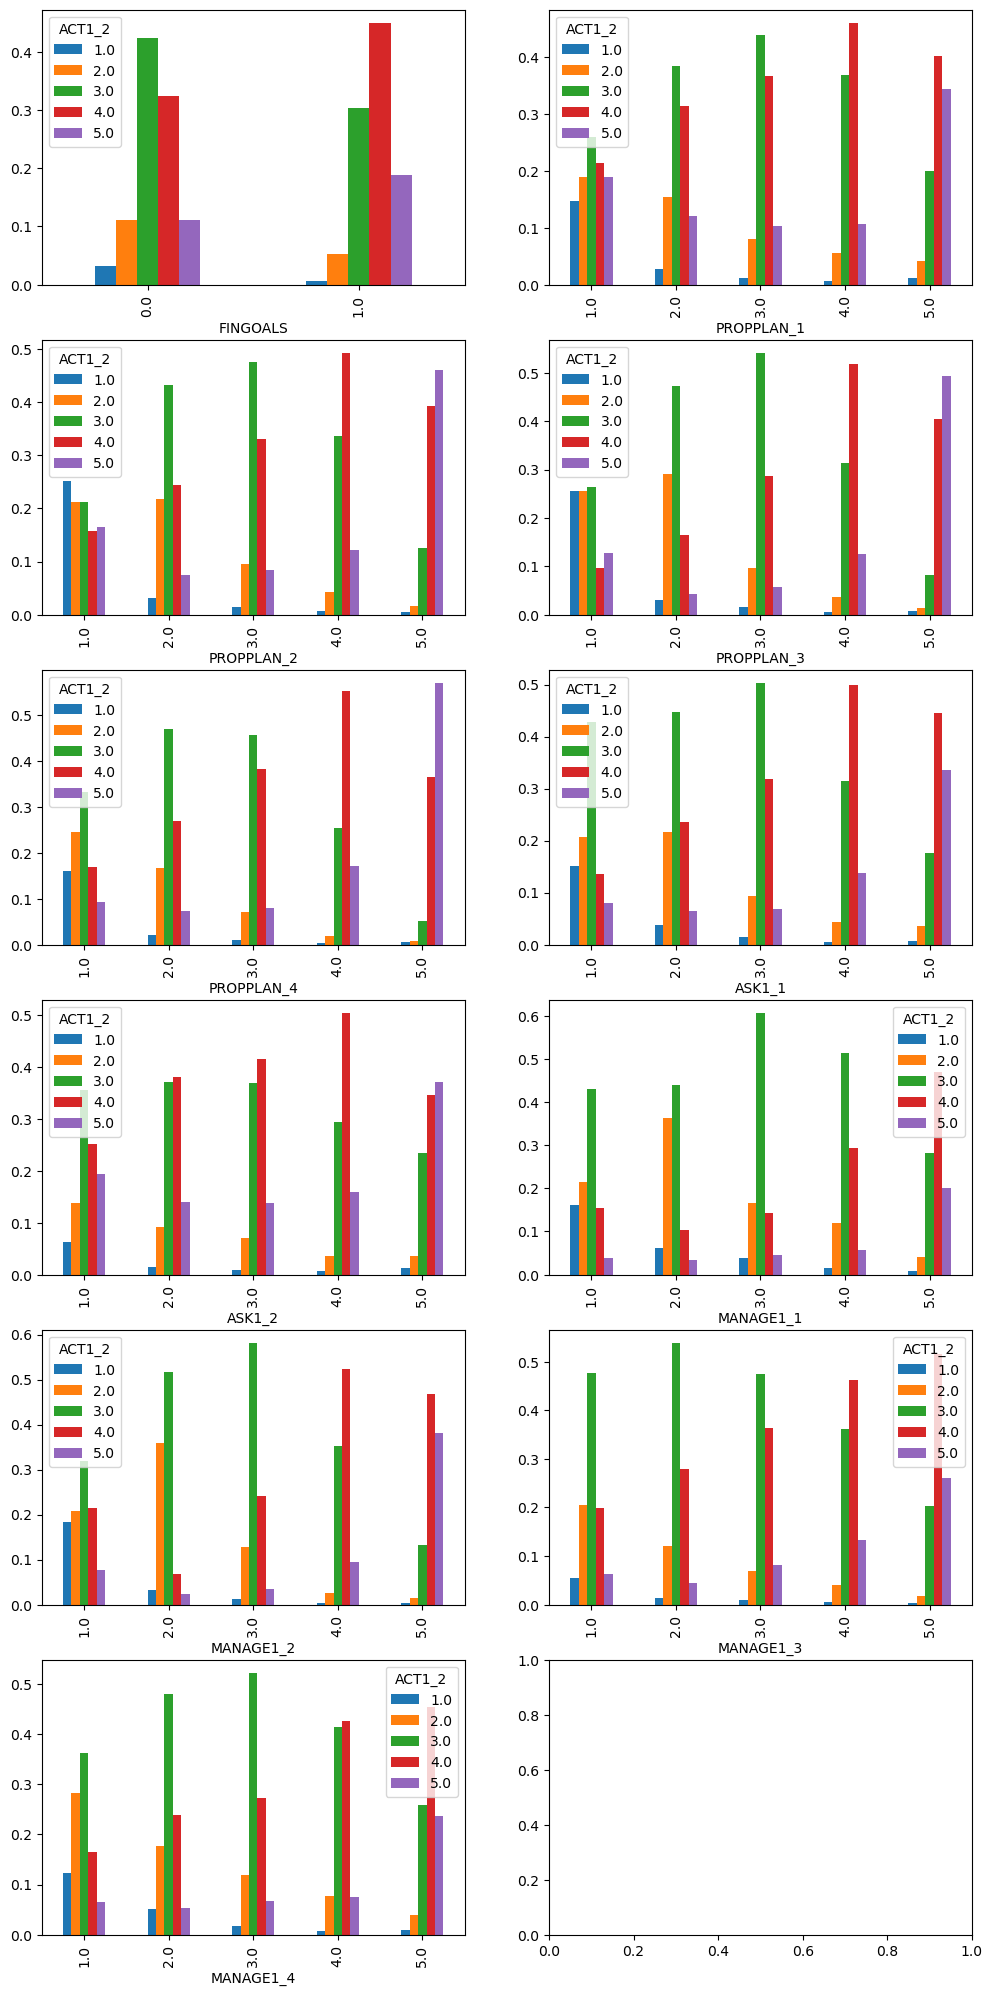

In [185]:
fig, axs = plt.subplots(6, 2, figsize=(12, 25))

feats = ['FINGOALS', 'PROPPLAN_1', 'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'ASK1_1', 'ASK1_2', 'MANAGE1_1', 'MANAGE1_2', 'MANAGE1_3', 'MANAGE1_4']
for i in range(1, 12):
    data.groupby(feats[i - 1])['ACT1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

__FINGOALS: Do you have a current or recent financial goal?__

Probably, people with similar financial responsability will have similar answers to this question.

Some variables that can relate people with similar financial responsability are: agecat, ACT1_2, SAVEHABIT, PROPPLAN_3, PROPPLAN_4, GOALCONF


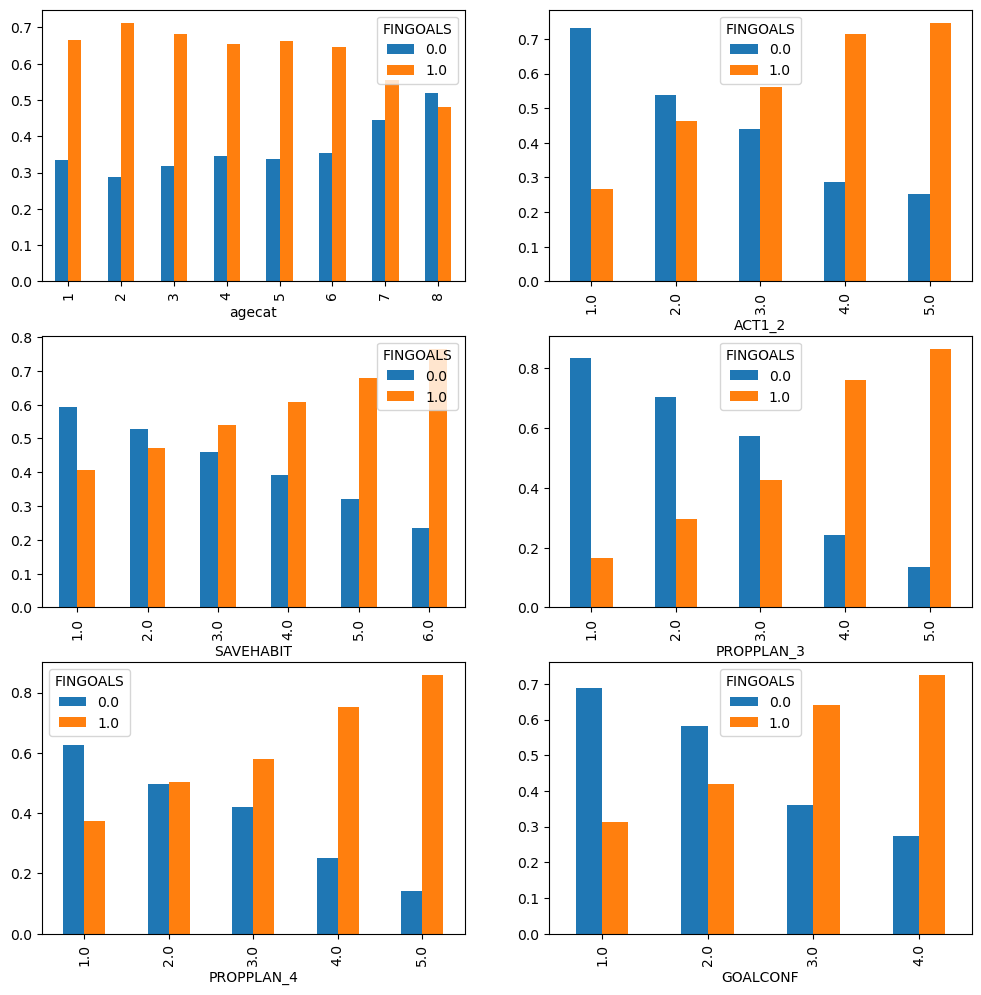

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

feats = ['agecat', 'ACT1_2', 'SAVEHABIT', 'PROPPLAN_3', 'PROPPLAN_4', 'GOALCONF']
for i in range(1, 7):
    data.groupby(feats[i - 1])['FINGOALS'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best features are: ACT1_2, SAVEHABIT, PROPPLAN_3, GOALCONF

__MANAGE2: Who in household makes financial decisions?__

Financial responsability question. Other answers that may be related to this one: PROPPLAN_1, PROPPLAN_2, PROPPLAN_4, MANAGE1_4, ASK1_2, KHscore, LMscore

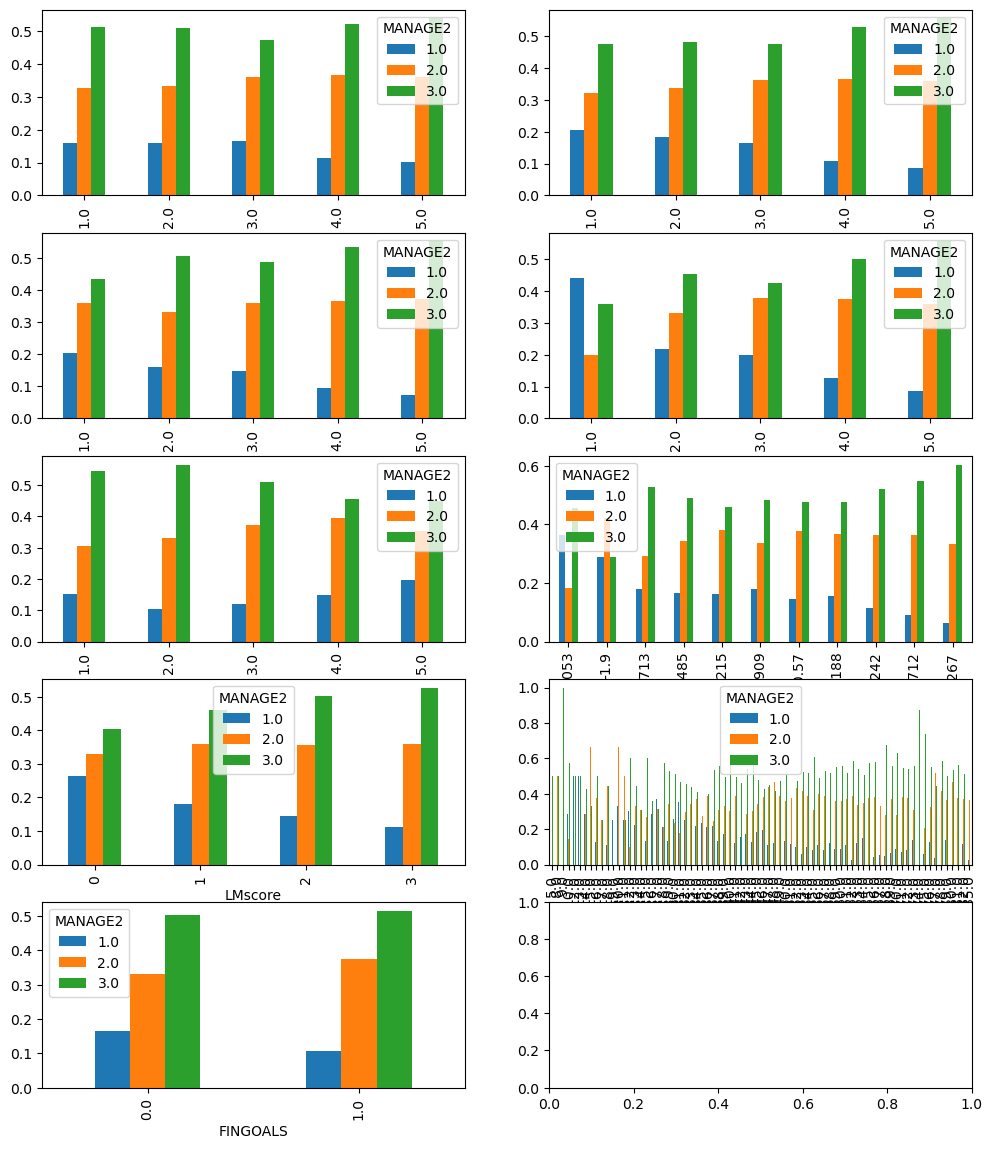

In [39]:
fig, axs = plt.subplots(5, 2, figsize=(12, 14))

features = ['PROPPLAN_1', 'PROPPLAN_2', 'PROPPLAN_4', 'MANAGE1_4', 'ASK1_2', 'KHscore', 'LMscore', 'FSscore', 'FINGOALS']
for i in range(1, 10):
    data.groupby(features[i - 1])['MANAGE2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

None is a very good discriminator. However, maybe some of them togheter have a greater discriminative power in predicting MANAGE2 missing values. Let's use MANAGE1_4, ASK1_2 and LMScore.

__SAVEHABIT__

'Putting money into savings is a habit for me'

Possibly related variables: FINGOALS, AUTOMATED_1, AUTOMATED_2, SELFCONTROL_1, SELFCONTROL_2, SELFOCONTROL_3, PROPPLAN_3, PROPPLAN_4, FINKNOWL2, SAVINGSRANGE, PRODHAVE_7, PRODUSE_3, BENEFITS_2, FINSOC2_2, FINSOC2_7, PRODHAVE_1

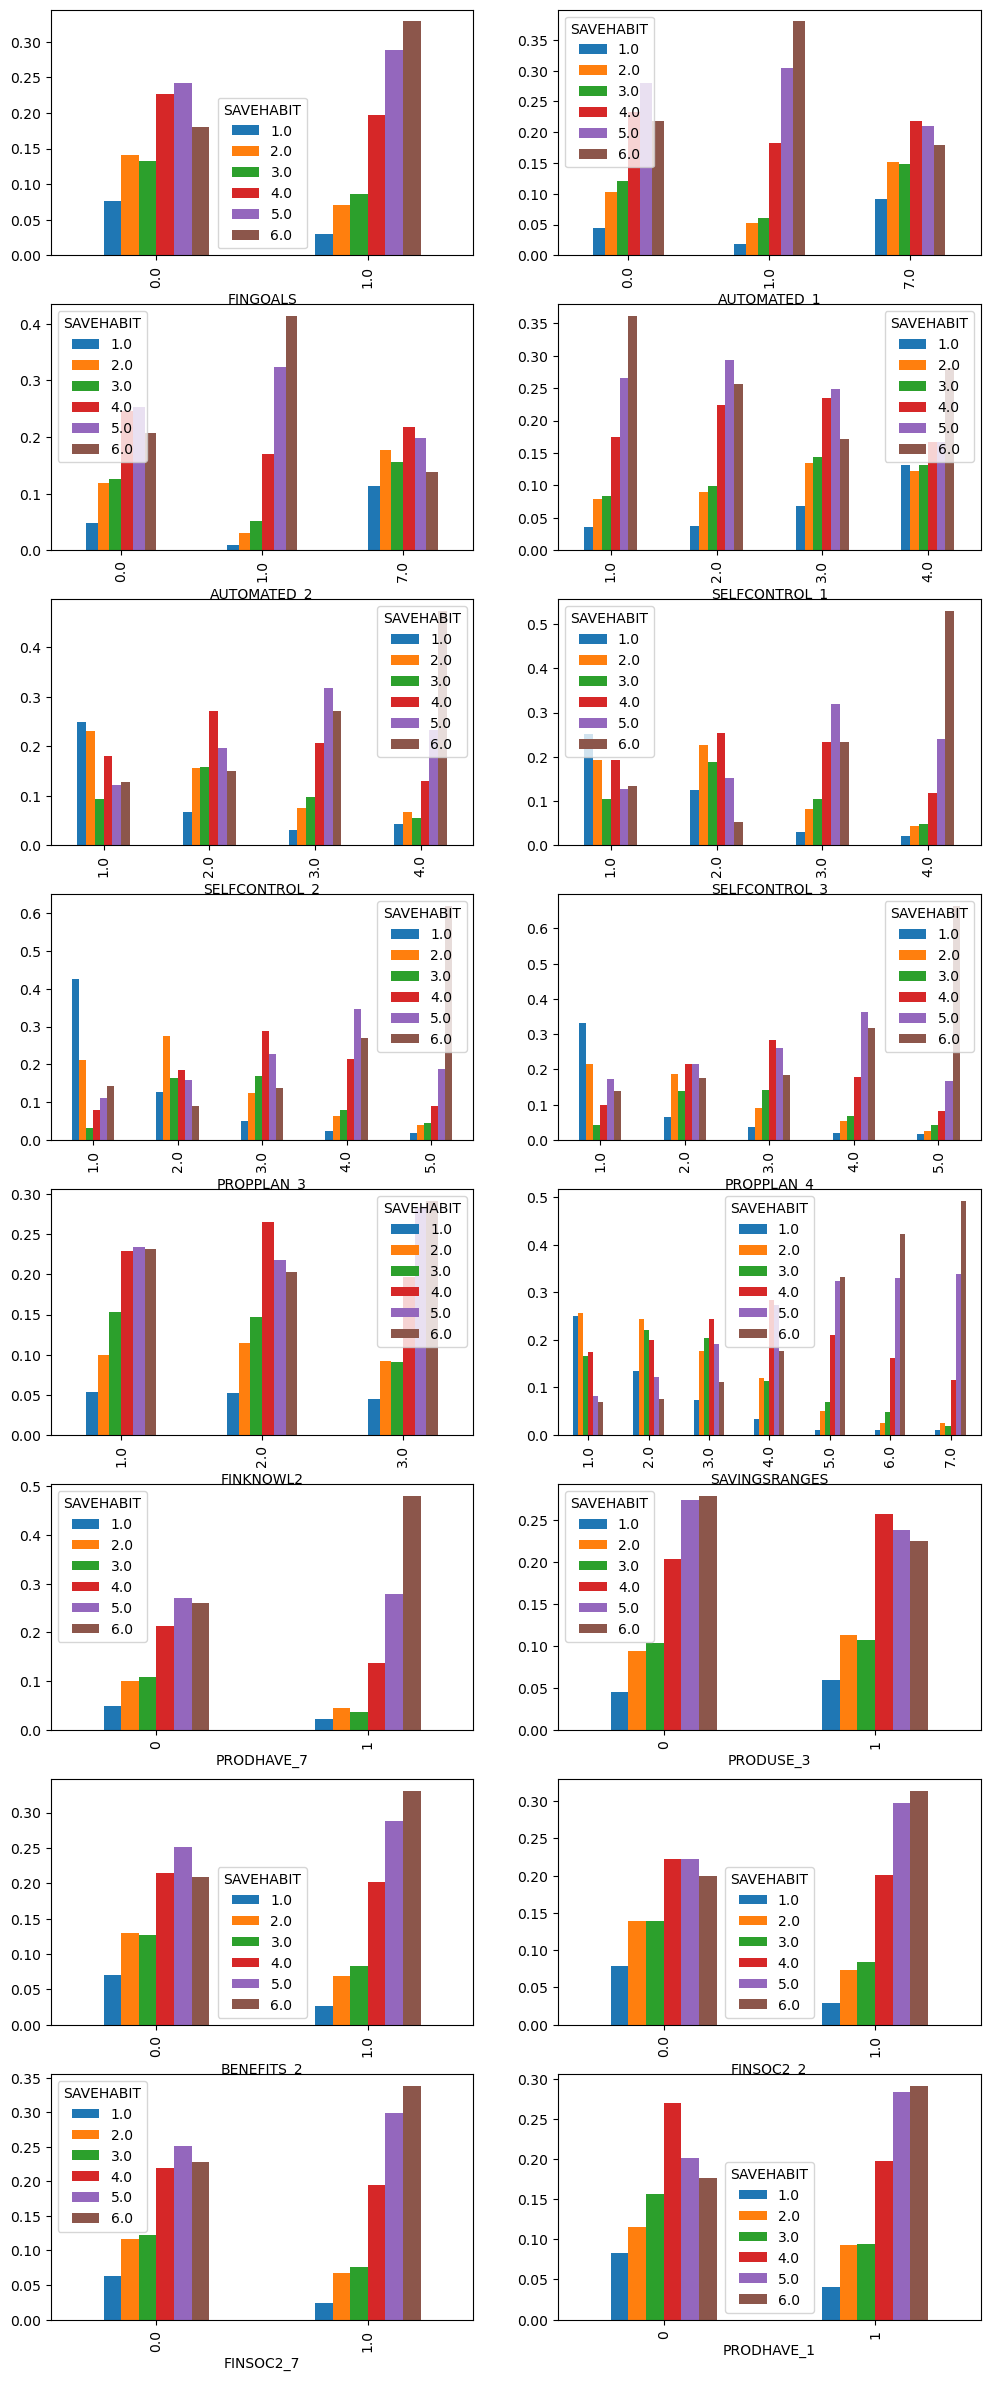

In [40]:
fig, axs = plt.subplots(8, 2, figsize=(12, 30))

features = ['FINGOALS', 'AUTOMATED_1', 'AUTOMATED_2', 'SELFCONTROL_1', 'SELFCONTROL_2', 'SELFCONTROL_3', 'PROPPLAN_3', 'PROPPLAN_4', 'FINKNOWL2', 'SAVINGSRANGES', 'PRODHAVE_7', 'PRODUSE_3', 'BENEFITS_2', 'FINSOC2_2', 'FINSOC2_7', 'PRODHAVE_1']
for i in range(1, 17):
    data.groupby(features[i - 1])['SAVEHABIT'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

The variables that discriminate the most are: FINGOALS, AUTOMATED_2, SELFCONTROL_2, PROPPLAN_3, SAVINGSRANGES, PRODHAVE_7, PRODHAVE_1

__FRUGALITY__

If I can re-use an item I already have, there's no sense in buying something new

Variables that are possibly related to this one: MATERIALISM_1, MATERIALISM_2, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3

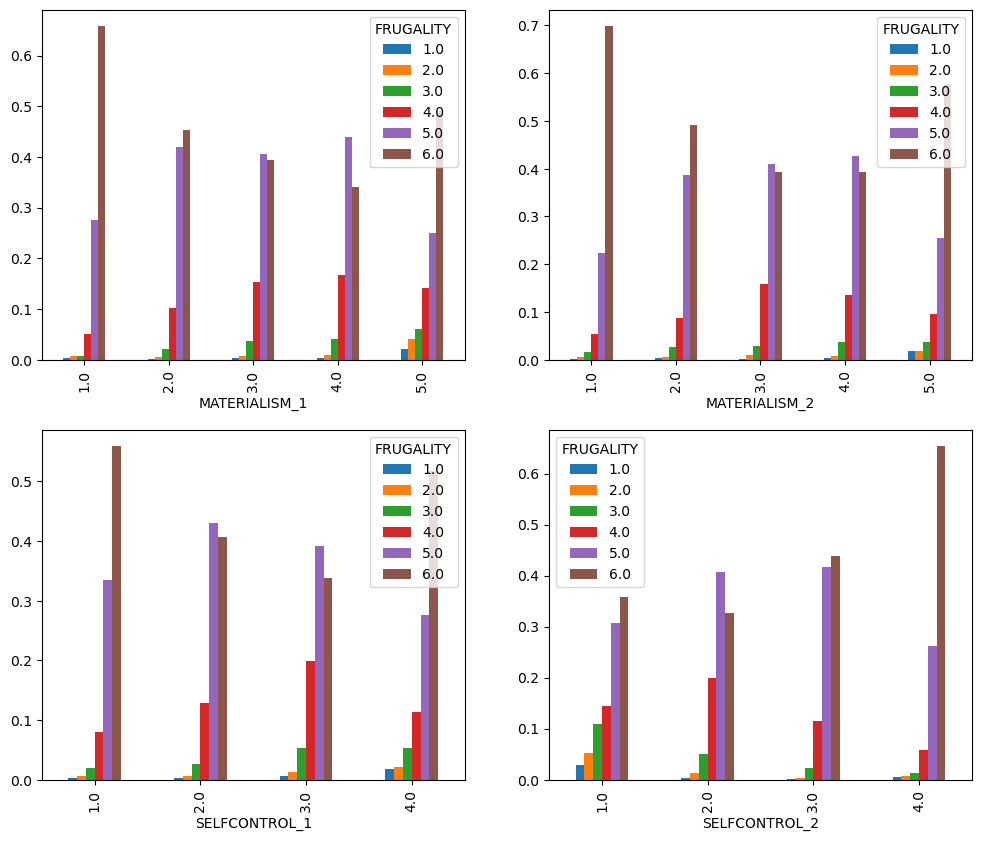

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

features = ['MATERIALISM_1', 'MATERIALISM_2', 'SELFCONTROL_1', 'SELFCONTROL_2', 'SELFCONTROL_3']
for i in range(1, 5):
    data.groupby(features[i - 1])['FRUGALITY'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Not very discriminatory. Maybe its better just to impute with the mode. Let's see the distribution.

<AxesSubplot:xlabel='FRUGALITY', ylabel='count'>

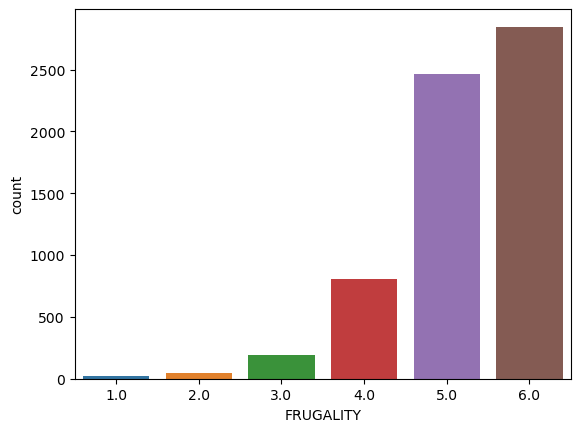

In [42]:
sns.countplot(x = 'FRUGALITY', data = data)

__AUTOMATED__

Do you currently have money automaticaly transfered to:

AUTOMATED_1: 'A Retirement Savings Account'

Possibly related variables: PRODHAVE_1, PRODHAVE_4, BENEFITS_2, SOCSEC1, SOCSEC3, EMPLOY, SAVEHABIT, SAVINGSRANGES


AUTOMATED_2: 'A Non-Retirement Savings Account'

Possibly related variables: PRODHAVE_1, PRODHAVE_6, PRODHAVE_7, EMPLOY, SAVEHABIT, SAVINGSRANGES

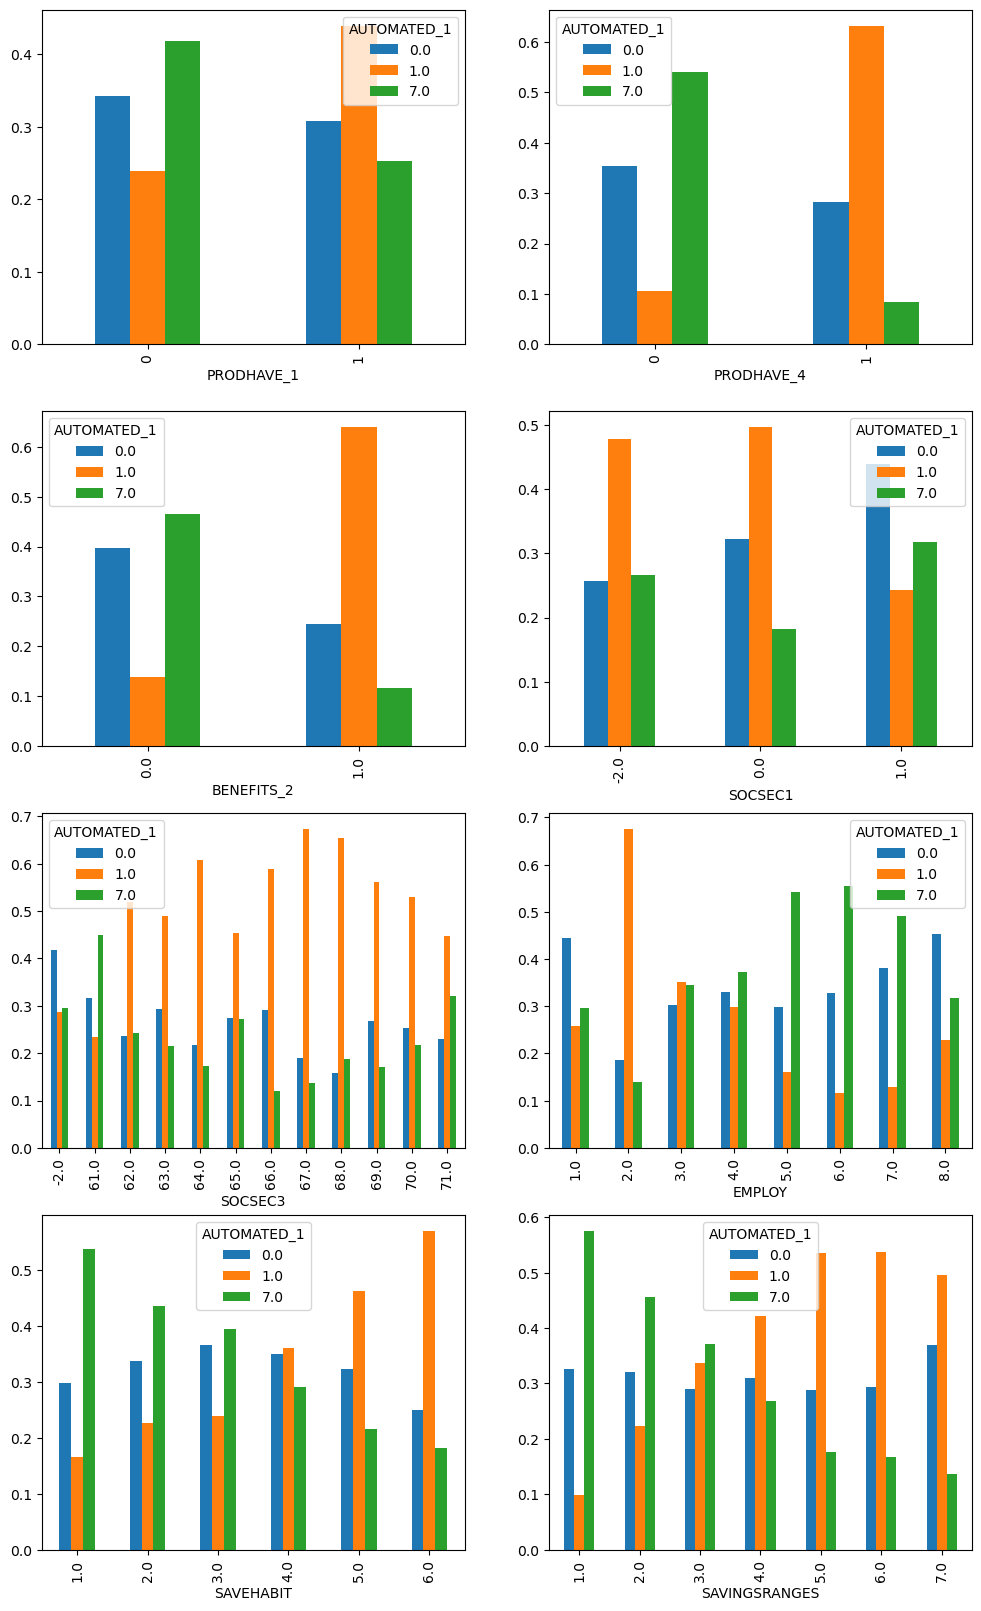

In [43]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))

features = ['PRODHAVE_1', 'PRODHAVE_4', 'BENEFITS_2', 'SOCSEC1', 'SOCSEC3', 'EMPLOY', 'SAVEHABIT', 'SAVINGSRANGES']

for i in range(1, 9):
    data.groupby(features[i - 1])['AUTOMATED_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

PRODHAVE_1, PRODHAVE_4, SAVEHABIT are the best ones to use to find the nearest neighbors and impute AUTOMATED_1

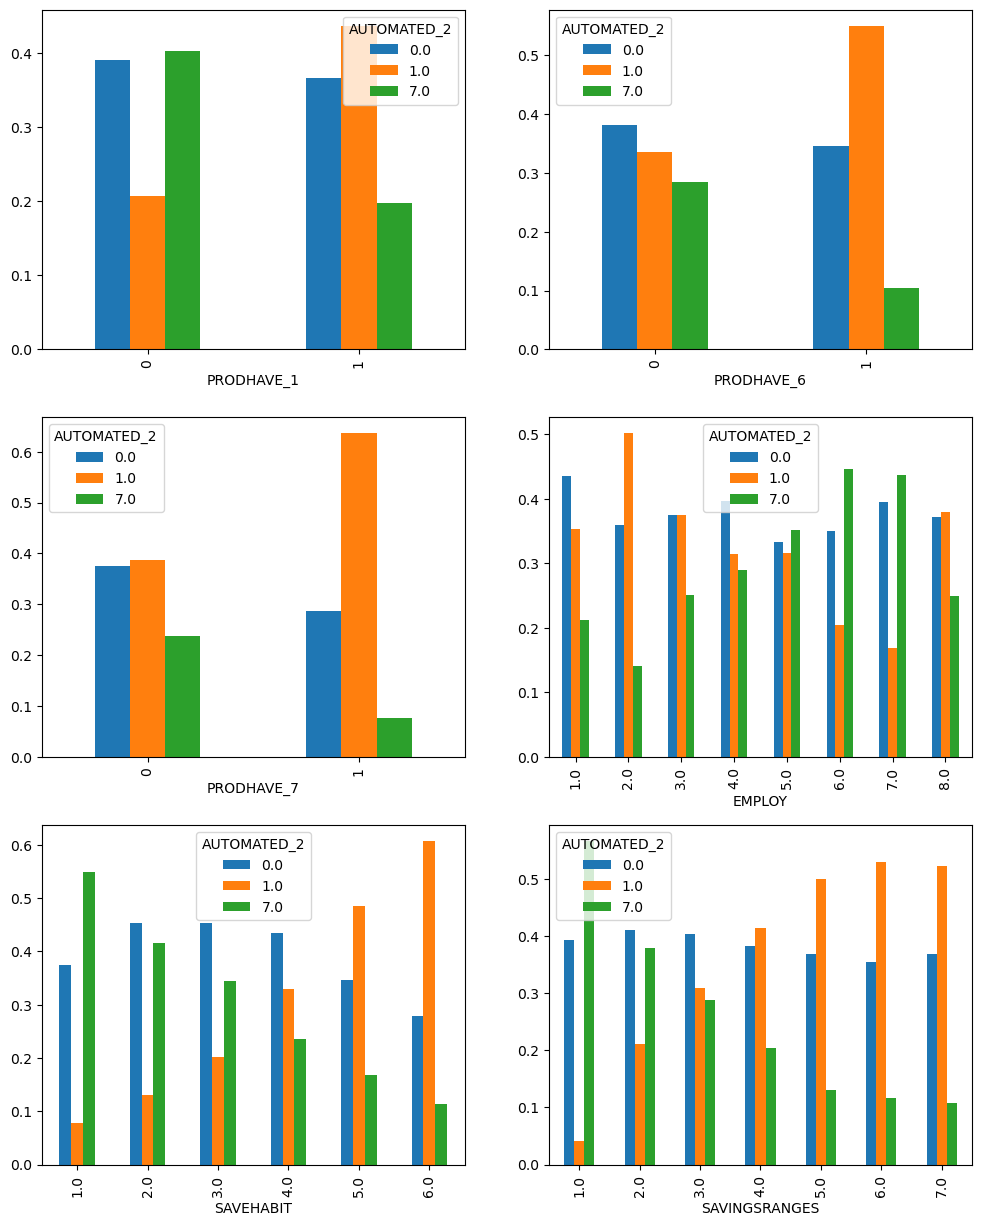

In [44]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

features = ['PRODHAVE_1', 'PRODHAVE_6', 'PRODHAVE_7', 'EMPLOY', 'SAVEHABIT', 'SAVINGSRANGES']

for i in range(1, 7):
    data.groupby(features[i - 1])['AUTOMATED_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

For AUTOMATED_2, the most discriminative features are PRODHAVE_1, PRODHAVE_6 and SAVEHABIT

__ASK__

ASK1_1: 'I do my own research before making decisions involving money'

Possibly related variables: PROPPLAN_1, PROPPLAN_2, PROPPLAN_3, PROPPLAN_4, MANAGE1_1, MANAGE1_2, MANAGE2, SELFCONTROL_1, SELFCONTROL_3, SAVEHABIT, GOALCONF, LMscore, KHscore, ENDSMEET, FRUGALITY

ASK1_2: 'I ask other people their opinions before making decisions involving money'

Possibly related variables: MANAGE2, CONSPROTECT2

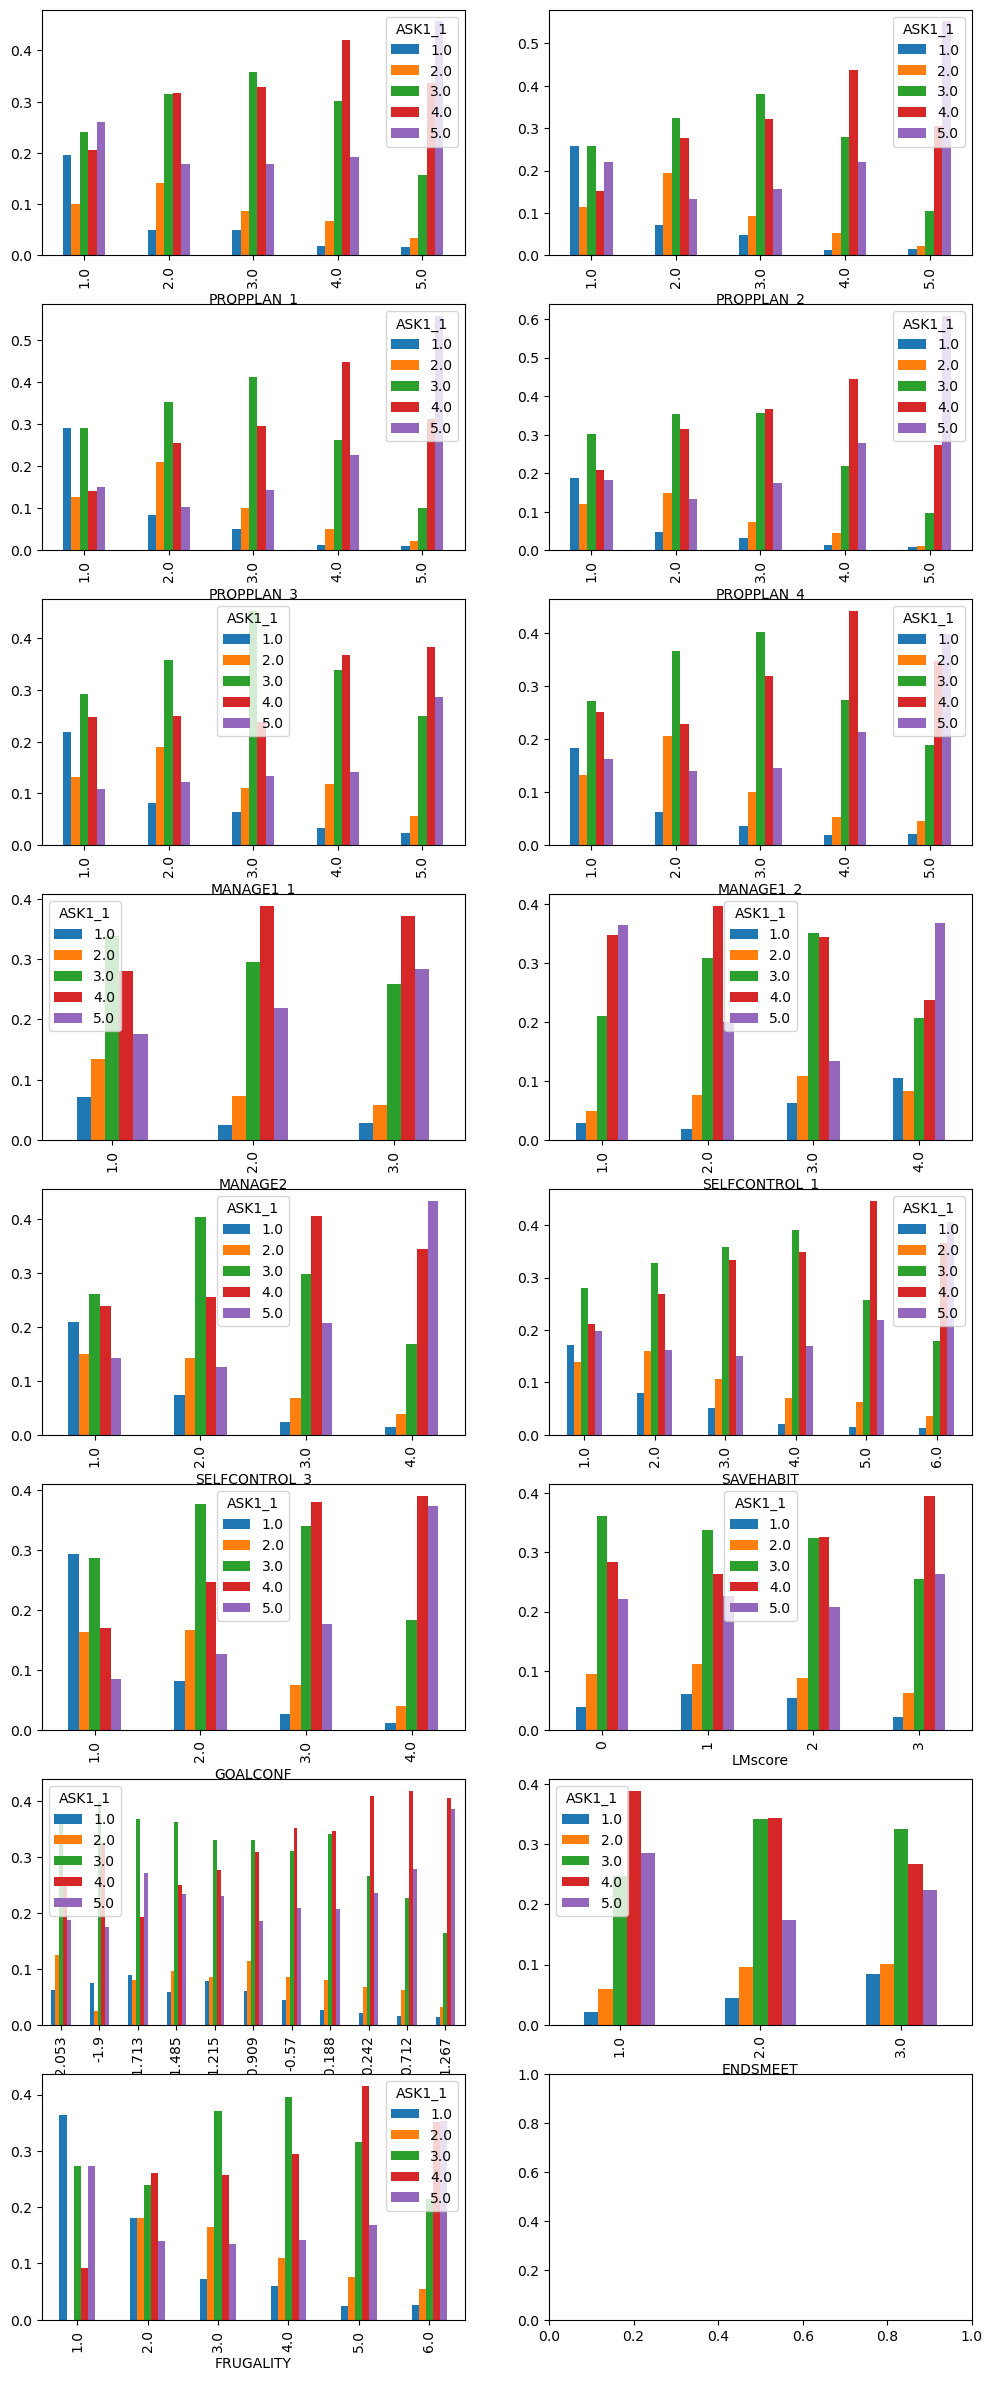

In [45]:
fig, axs = plt.subplots(8, 2, figsize=(12, 30))

features = ['PROPPLAN_1', 'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'MANAGE1_1', 'MANAGE1_2', 'MANAGE2', 'SELFCONTROL_1', 'SELFCONTROL_3', 'SAVEHABIT', 'GOALCONF', 'LMscore', 'KHscore', 'ENDSMEET', 'FRUGALITY']

for i in range(1, 16):
    data.groupby(features[i - 1])['ASK1_1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

MANAGE1_2, MANAGE2, GOALCONF, KHscore, FRUGALITY discriminate well

MANAGE1_2: ordinal
<br>
MANAGE2: categorical
<br>
GOALCONF: ordinal
<br>
KHscore: numerical
<br>
FRUGALITY: ordinal
<br>

distance: euclidean(ordinal + numerical) + hamming (categorical)

<AxesSubplot:xlabel='CONSPROTECT2'>

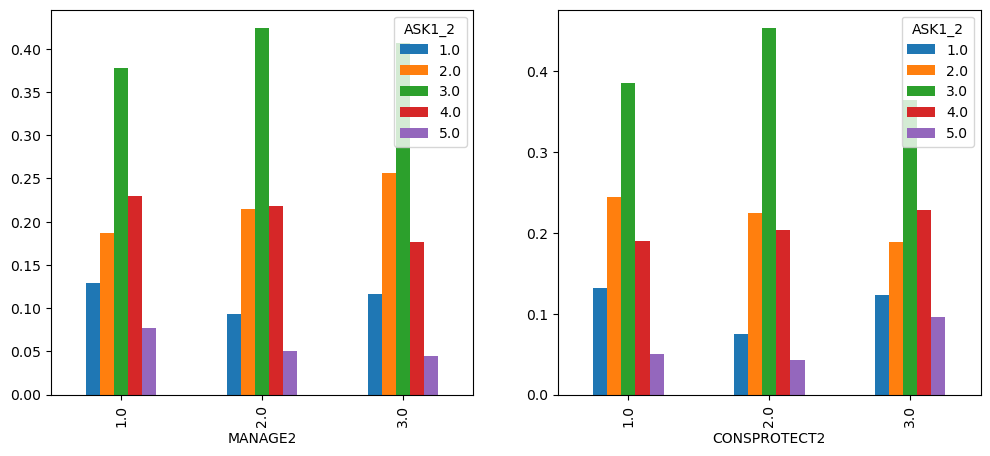

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

data.groupby('MANAGE2')['ASK1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[0])
data.groupby('CONSPROTECT2')['ASK1_2'].value_counts(normalize = True).unstack().plot.bar(ax = axs[1])

Not very discriminative. Let's look at the distribution of this feature

<AxesSubplot:xlabel='ASK1_2', ylabel='count'>

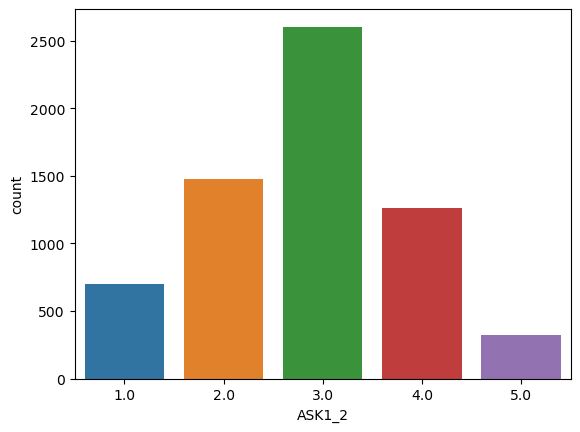

In [47]:
sns.countplot(x = 'ASK1_2', data = data)

Normally distributed. It's better to use the mode.

__SUBNUMERACY__

SUBNUMERACY1: 'How good are you at working with percentages?' -> objective and probably correlated with numerical predisposal

SUBNUMERACY2: 'Prefers words for expressions of probabilities' -> subjective

<AxesSubplot:xlabel='ON2correct'>

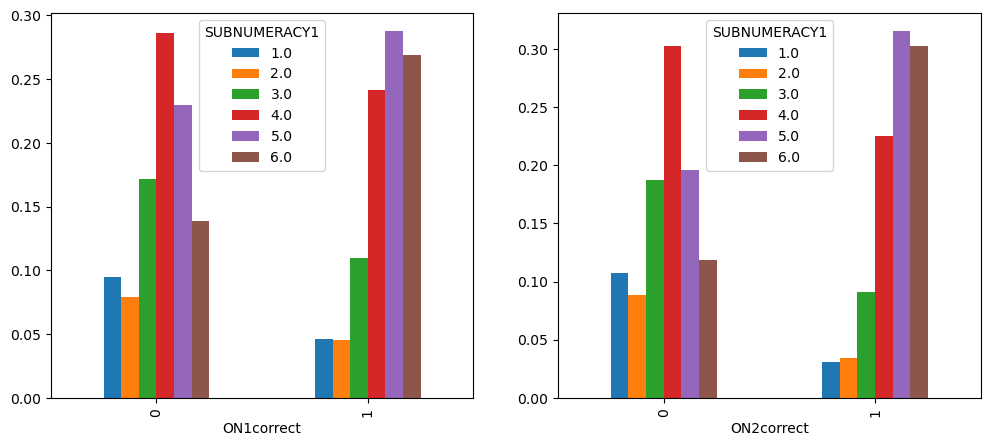

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

data.groupby('ON1correct')['SUBNUMERACY1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[0])
data.groupby('ON2correct')['SUBNUMERACY1'].value_counts(normalize = True).unstack().plot.bar(ax = axs[1])

Moderately good discriminators

<AxesSubplot:xlabel='SUBNUMERACY2', ylabel='count'>

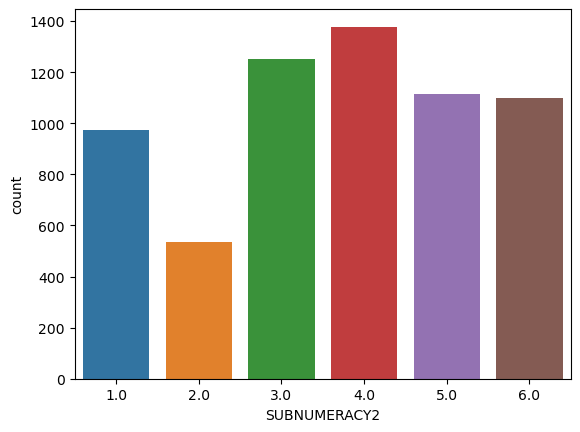

In [49]:
sns.countplot(x = 'SUBNUMERACY2', data = data)

__CHANGEABLE__

'Belief that ability to manage money is NOT changeable'

Subjective question that is not related to any other question. The distribution of the questions is the normal distribution, so let's use the mode to impute the missing values.

<AxesSubplot:xlabel='CHANGEABLE', ylabel='count'>

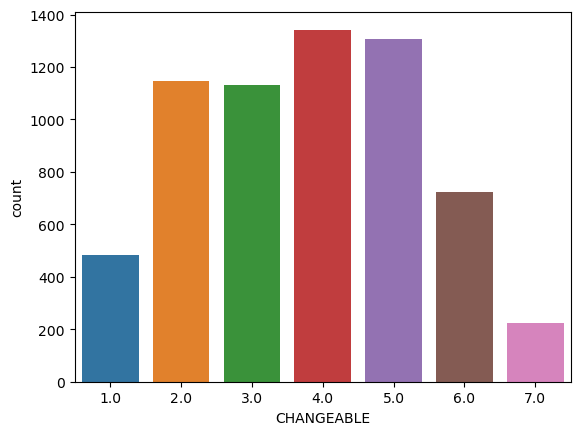

In [50]:
sns.countplot(x = 'CHANGEABLE', data = data)

__GOALCONF__

'Confidence in own ability to achieve financial goals'

Possibly related questions: SBW_2, FWBscore, FSscore, FINGOALS, PROPPLAN_3, PROPPLAN_4, SAVEHABIT,ASK1_1, ENDSMEET, SAVINGSRANGES, MATHARDSHIP_1, COLLECT, REJECTED_1, ABSORBSHOCK, SELFCONTROL_3, SCFHORIZON

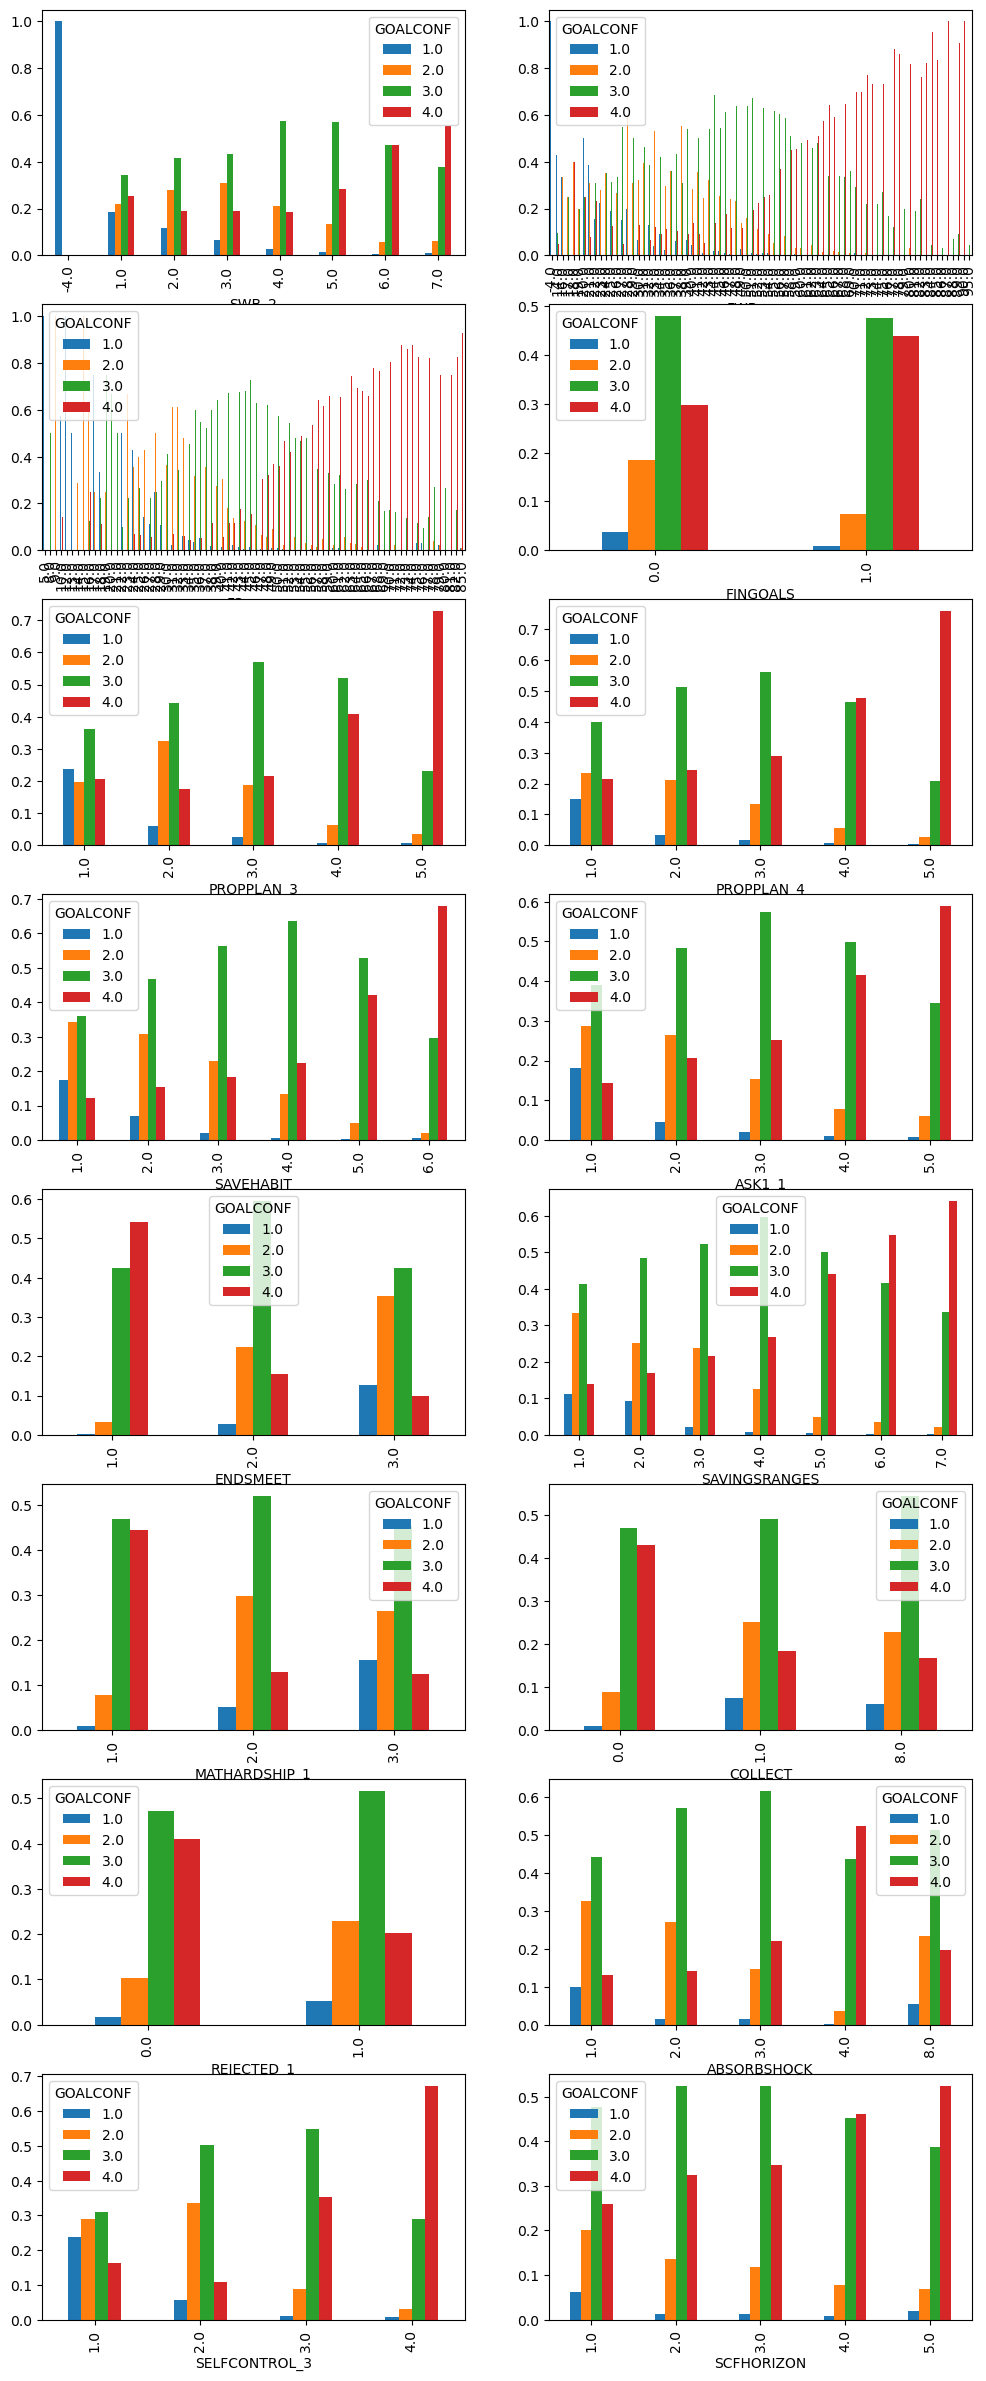

In [51]:
fig, axs = plt.subplots(8, 2, figsize=(12, 30))

feats = ['SWB_2', 'FWBscore', 'FSscore', 'FINGOALS', 'PROPPLAN_3', 'PROPPLAN_4', 'SAVEHABIT', 'ASK1_1', 'ENDSMEET', 'SAVINGSRANGES', 'MATHARDSHIP_1', 'COLLECT', 'REJECTED_1', 'ABSORBSHOCK', 'SELFCONTROL_3', 'SCFHORIZON']

for i in range(1, 17):
    data.groupby(feats[i - 1])['GOALCONF'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: FWBscore, SAVEHABIT, ASK1_1, ENDSMEET, SELFCONTROL_3

__ENDSMEET__

'Difficulty of covering monthly expenses and bills'

Possibly related variables: SWB_1, SWB_2, FWBscore, MANAGE1_1, AMNAGE1_2, MANAGE1_3, GOALCONF, SAVINGSRANGES, VOLATILITY, MATHARSHIP_1, MATHARSHIP_2, MATHARSHIP_3, MATHARSHIP_4, MATHARSHIP_5, MATHARSHIP_6, COLLECT, REJECTED_1, REJECTED_2, ABSORBSHOCK, HHEDUC, EMPLOY, PPEDUC, PPETHM, PPGENDER, PPINCIMP

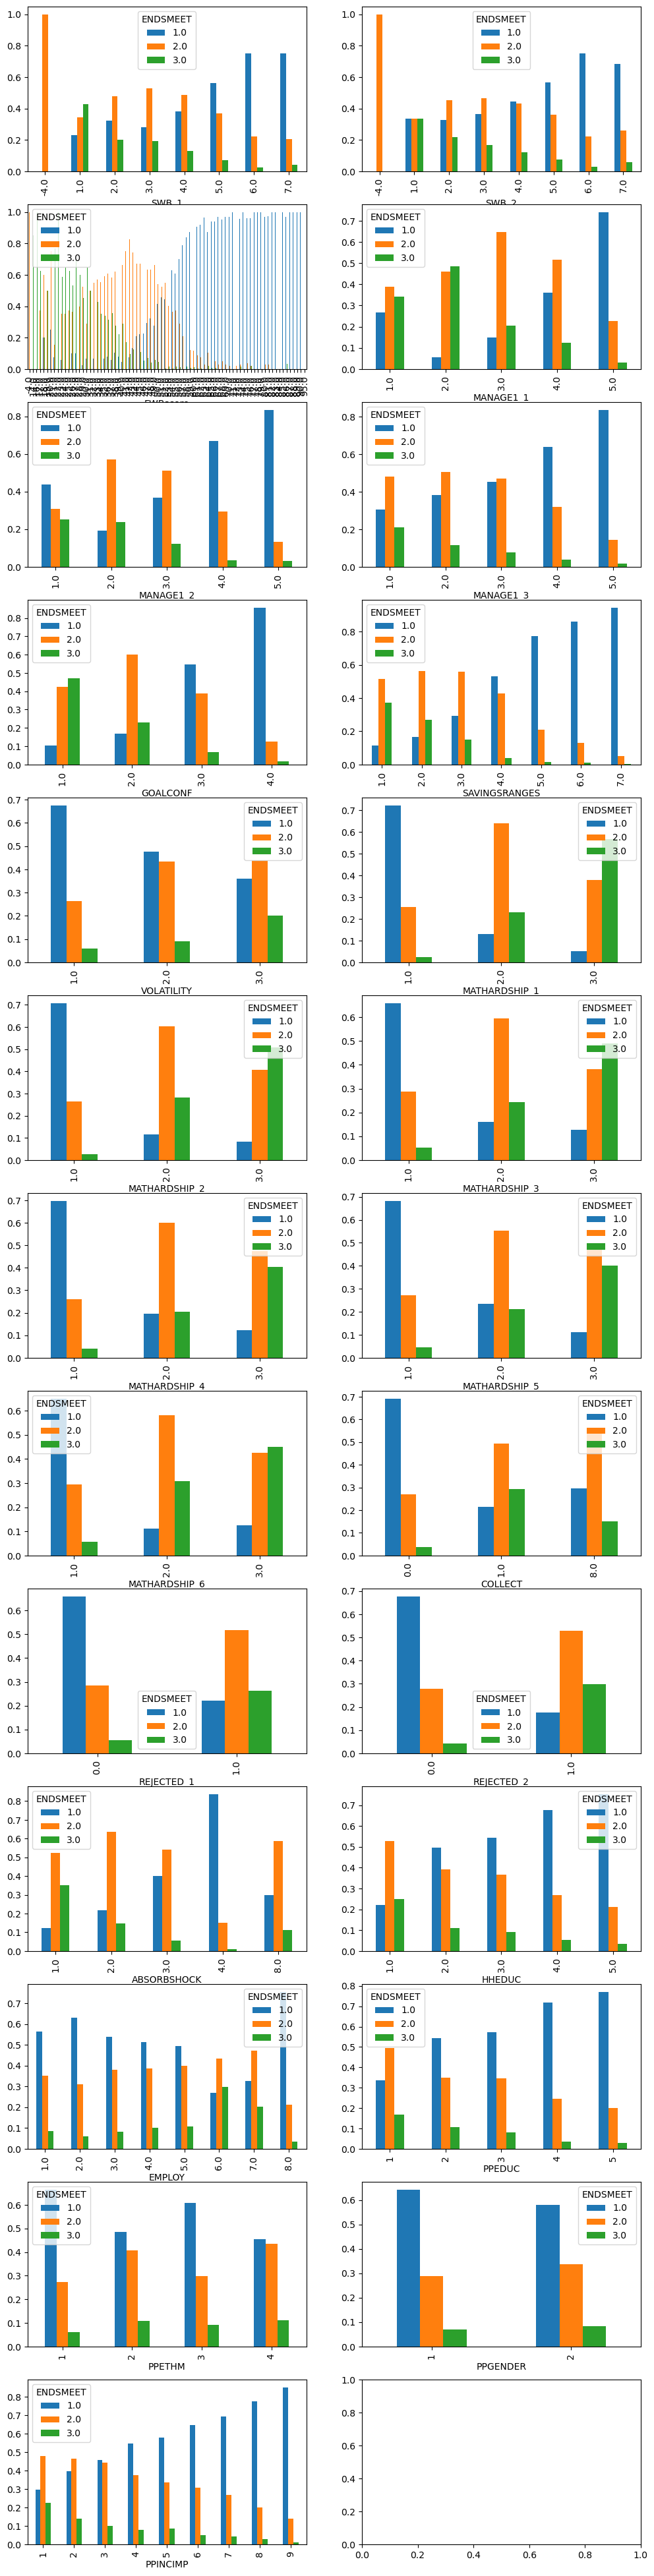

In [52]:

fig, axs = plt.subplots(13, 2, figsize=(12, 50))

feats = ['SWB_1', 'SWB_2', 'FWBscore', 'MANAGE1_1', 'MANAGE1_2', 'MANAGE1_3', 'GOALCONF', 'SAVINGSRANGES', 'VOLATILITY', 'MATHARDSHIP_1', 'MATHARDSHIP_2', 'MATHARDSHIP_3', 'MATHARDSHIP_4', 'MATHARDSHIP_5', 'MATHARDSHIP_6', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'ABSORBSHOCK', 'HHEDUC', 'EMPLOY', 'PPEDUC', 'PPETHM', 'PPGENDER', 'PPINCIMP']
for i in range(1, 26):
    data.groupby(feats[i - 1])['ENDSMEET'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best features: SWB_1, FWBscore, SAVINGSRANGES, GOALCONF, MATHARDSHIP_1, REJECTED_1, HHEDUC, PPEDUC, PPINCIMP

__HOUSING__

'Which one of the following best describes your housing situation?'

I own my own hone
<br>
I rent
<br>
I do not currently own or rent

Let's see distribution

<AxesSubplot:xlabel='HOUSING', ylabel='count'>

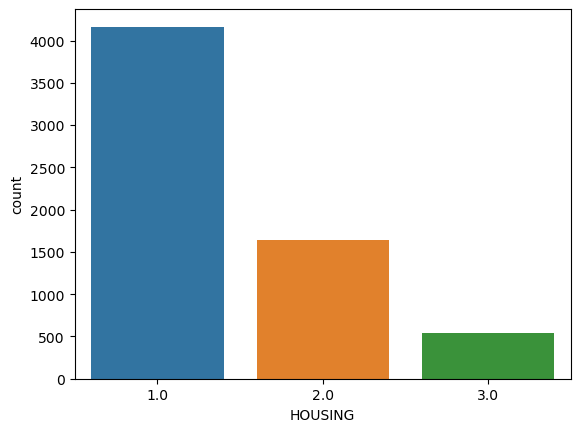

In [53]:
sns.countplot(x = 'HOUSING', data = data)

Possible related variables:

HOUSERANGES, HOUSESAT, agecat, MATHARDSHIP_3, SAVINGSRANGES, ENDSMEET, EMPLOY

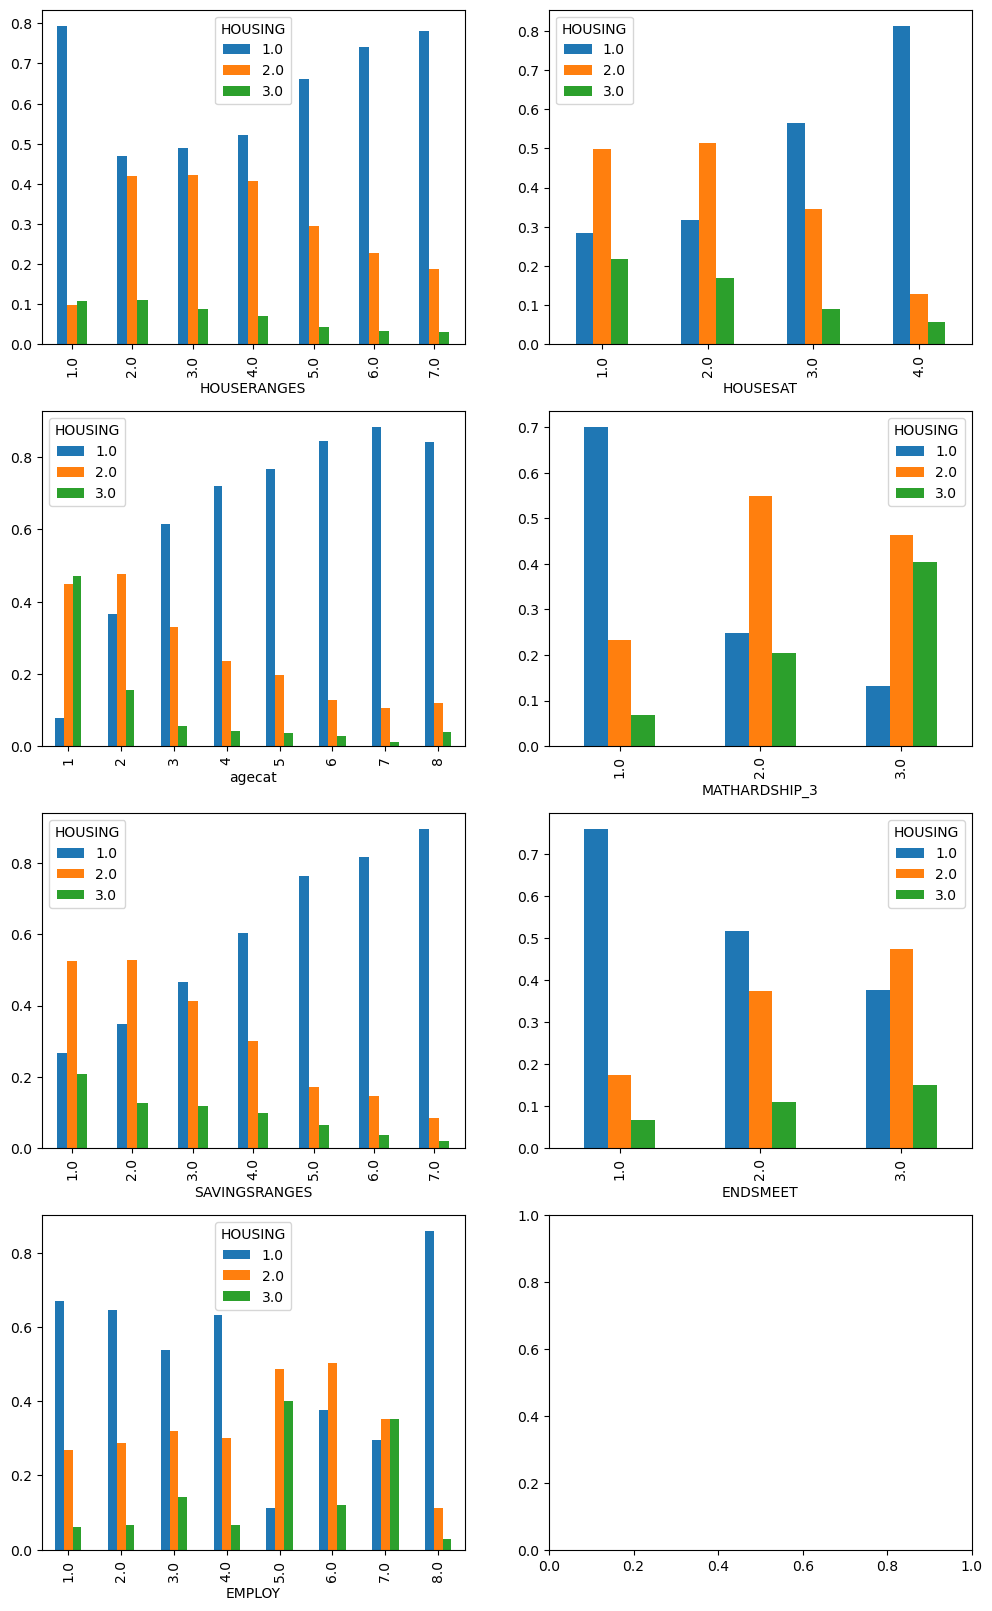

In [56]:

fig, axs = plt.subplots(4, 2, figsize=(12, 20))

feats = ['HOUSERANGES', 'HOUSESAT', 'agecat', 'MATHARDSHIP_3', 'SAVINGSRANGES', 'ENDSMEET', 'EMPLOY']
for i in range(1, 8):
    data.groupby(feats[i - 1])['HOUSING'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: ENDSMEET, SAVINGSRANGES, agecat, HOUSESAT, MATHARDSHIP_3

__LIVINGARRANGEMENTS__

<AxesSubplot:xlabel='LIVINGARRANGEMENT', ylabel='count'>

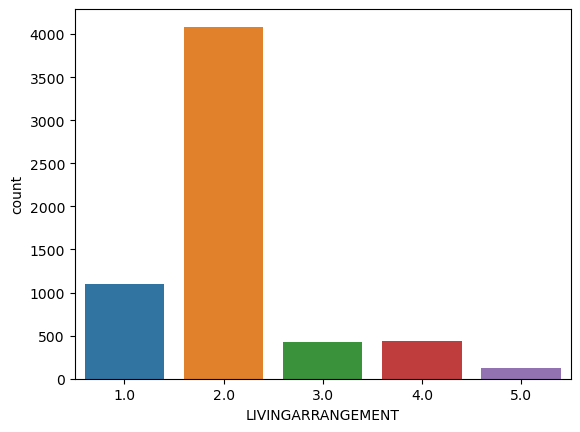

In [187]:
sns.countplot(x = 'LIVINGARRANGEMENT', data = data)

__HOUSERANGES__

'About how much do you pay for your home each month?'

<AxesSubplot:xlabel='HOUSERANGES', ylabel='count'>

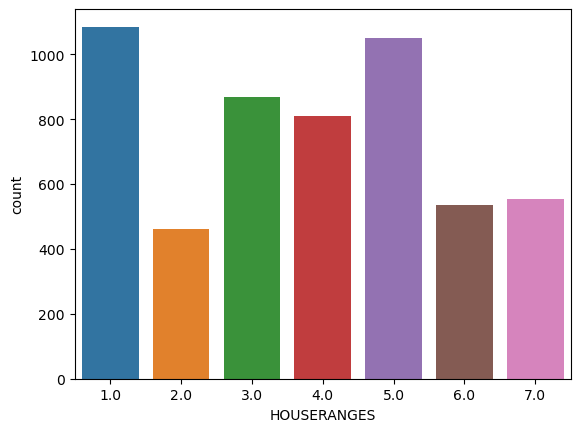

In [188]:
sns.countplot(x = 'HOUSERANGES', data = data)

Possibly related variables: FWBScore, PROPPLAN_3, MANAGE1_3, SAVEHABIT, GOALCONF, ENDSMEET, HOUSING, LIVINGARRANGEMENTS, PRODHAVE_1, ERANERS, VOLATILITY, MATHARDSHIP_3, COLLECT, ABSORBSHOCK

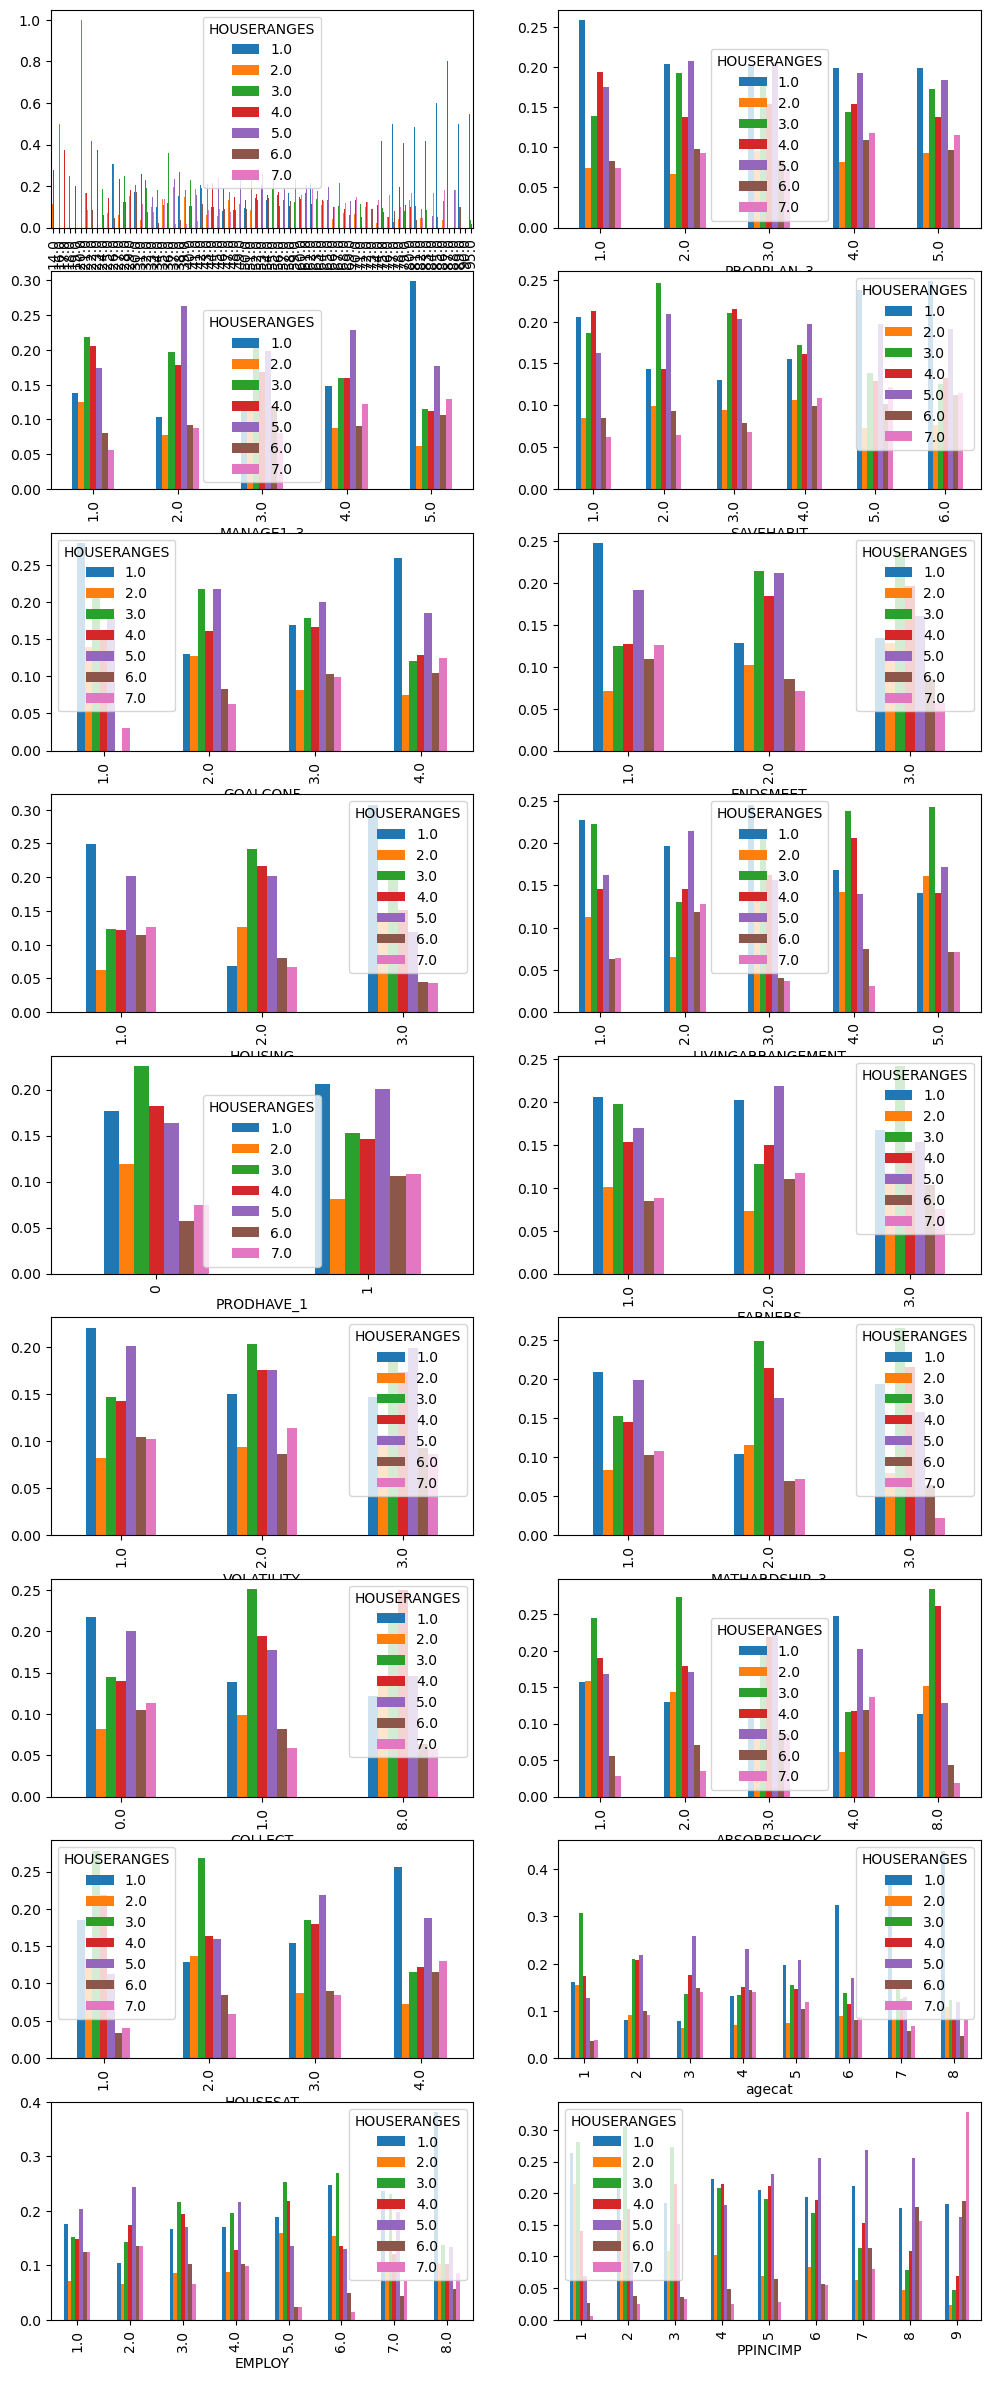

In [193]:
fig, axs = plt.subplots(9, 2, figsize=(12, 30))

feats = ['FWBscore', 'PROPPLAN_3', 'MANAGE1_3', 'SAVEHABIT', 'GOALCONF', 'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'PRODHAVE_1', 'EARNERS', 'VOLATILITY', 'MATHARDSHIP_3', 'COLLECT', 'ABSORBSHOCK', 'HOUSESAT', 'agecat', 'EMPLOY', 'PPINCIMP']
for i in range(1, 19):
    data.groupby(feats[i - 1])['HOUSERANGES'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: FWBscore, COLLECT, ABSORBSCHOCK, HOSUING, GOALCONF, MANAGE1_3, ENDSMEET, SAVEHABIT, HOUSESAT, PPINCMP

#TODO: rever

## Target and Weights variables exploration

Data types:

In [ ]:
data.dtypes.value_counts()

int64      214
float64      2
dtype: int64

### Weights

__Variable finalwt__: the weights included in the dataset are important for ensuring that the results obtained from the survey are representative of the United States population. These weights are used to account for variations in the probability of selection and to adjust for differential nonresponse across different socioeconomic groups.

In machine learning, when using weighted data, you can include the weights in the model training process to adjust for sampling bias. The exact method for including weights depends on the specific machine learning algorithm you are using.

For example, if you are using scikit-learn library in Python, you can use the 'sample_weight' parameter in the 'fit' method to specify the weights for each training example. Other machine learning libraries may have different methods for incorporating weights.

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='finalwt', ylabel='Density'>

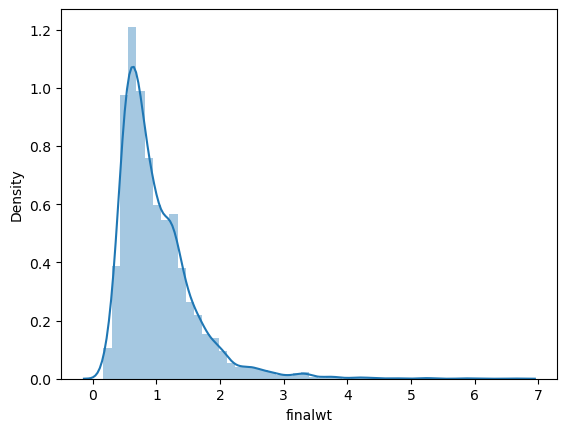

In [45]:
sns.distplot(data['finalwt'])


### Target

__Target variable__: fpl (Federal poverty level)

- <100% Federal Poverty Level
- 100-199% Federal Poverty Level
- 200%+ Federal Poverty Level

In [ ]:
data.fpl.value_counts(normalize = True)

3    0.762277
2    0.134345
1    0.103378
Name: fpl, dtype: float64

The dataset is quite imbalanced